In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

import os

from PlottingScripts import CV, Spline, Tune1, sampHist, distVar,distplot_wratio

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Set scalings

In [17]:
#old tagger
#DIRT_POT = 3.2571504301e+20
#NUMU_POT = 1.219190611900899e+21
#NUE_POT = 1.31390317541e+23
#DATA_POT = 4.4e19    #3.456e+19
#EXT_POT = (12315978.0) / float (7704849.0) * DATA_POT# 14542235.0 / 10640228.0 * DATA_POT

#wc tagger
NUMU_POT = 4.71579e+20
NUE_POT  = 9.80259e+22
DIRT_POT = 2.61947e+20
RUN1_POT = 4.403e+19   #  run1
RUN3_POT = 8.808e+18 # run3 (no beam quality cut)
EXTRUN1_POT = (22474918.0) / float ( 9776965.0) * RUN1_POT #run1
EXTRUN3_POT = (22474918.0) / float ( 2264083.0) * RUN3_POT

POT_SCALE_FACTOR = RUN1_POT
NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXTRUN1_SCALE = POT_SCALE_FACTOR / float(EXTRUN1_POT)
EXTRUN3_SCALE = POT_SCALE_FACTOR / float(EXTRUN3_POT)
RUN1_SCALE = POT_SCALE_FACTOR / float(RUN1_POT)
RUN3_SCALE = POT_SCALE_FACTOR / float(RUN3_POT)
DIRT_SCALE = POT_SCALE_FACTOR / float(DIRT_POT)

print(EXTRUN1_POT)

1.0121450159021741e+20


## Load up parquets with our samples and apply precuts

In [18]:
tag = 'Mar31-WC'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts

df_numu_presel = pd.read_parquet('../data/pickles/numu_nodupes_%s.parquet'%tag).query(precut)
df_nue_presel = pd.read_parquet('../data/pickles/nue_nodupes_%s.parquet'%tag).query(precut)
df_ext_presel = pd.read_parquet('../data/pickles/ext_nodupes_%s.parquet'%tag).query(precut)
df_run1_presel = pd.read_parquet('../data/pickles/datarun1_nodupes_%s.parquet'%tag).query(precut)
df_run3_presel = pd.read_parquet('../data/pickles/datarun3_nodupes_%s.parquet'%tag).query(precut)
df_dirt_presel = pd.read_parquet('../data/pickles/dirt_nodupes_%s.parquet'%tag).query(precut)

## Define our histogram stacks

In [19]:
# sampHist(df containing sample;string of sample label for plotting; string of color for plotting; 1=CV weight/0=no genieweight; scale factor)

simpleHists = []
simpleHists.append(sampHist(df_numu_presel,'numu','crimson',1,NUMU_SCALE))
simpleHists.append(sampHist(df_nue_presel,r'$\nu_e$ Intrinsic Overlay','pink',1,NUE_SCALE))
simpleHists.append(sampHist(df_dirt_presel,'Dirt','peru',1,DIRT_SCALE))
simpleHists.append(sampHist(df_ext_presel,'ExtBNB','fuchsia',0,EXTRUN1_SCALE))

sampleHists = []
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_CCQE']"),r'$\nu_\mu$ CCQE','blue',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_MEC']"),r'$\nu_\mu$ MEC','cyan',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_piplusminus']"),r'$\nu_\mu$ Res $\pi^{+/-}$','darkgreen',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_pizero']"),r'$\nu_\mu$ Res $\pi^{0}$','greenyellow',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_other','nue_other','nue_MEC','nue_piplusminus','nue_pizero']"),r'BNB Other','gold',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['badreco']"),r'BNB Bad Reco','coral',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['offvtx']"),r'BNB 1L1P Off Vertex','grey',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['nLmP']"),r'BNB Not 1L1P','crimson',1,NUMU_SCALE))
sampleHists.append(sampHist(df_nue_presel,r'$\nu_e$ Intrinsic Overlay','pink',1,NUE_SCALE))
sampleHists.append(sampHist(df_dirt_presel,'Dirt','peru',1,DIRT_SCALE))
sampleHists.append(sampHist(df_ext_presel,'ExtBNB','fuchsia',0,EXTRUN1_SCALE))

run1Hist = sampHist(df_run1_presel,'bnb5e19 [run1]','',0,RUN1_SCALE)
run3Hist = sampHist(df_run3_presel,'bnb1e19 [run3]','',0,RUN3_SCALE)

In [20]:
nbins = 30
s_annotation = 'All Precuts, Orthogonality Cuts\nand No Duplicate Vertices'

Events: 3538.0
Min Bin ct (data): 0.0


Text(0.75, 0.6, 'All Precuts, Orthogonality Cuts\nand No Duplicate Vertices')

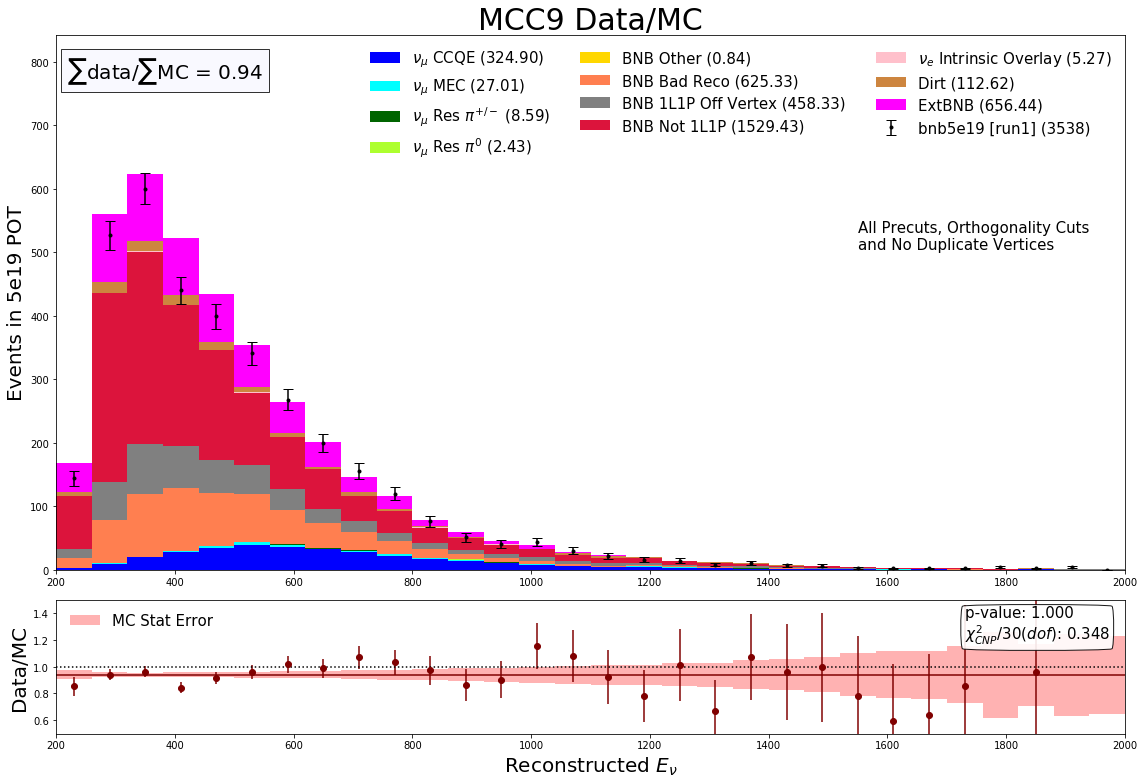

In [24]:
# distplot_wratio(string of variable name, number of bins, range, stacked histo list, data list, name for x-axis)
# for other arguments, see PlottingScripts.py

vartest = 'Enu_1m1p'
varname = r'Reconstructed $E_\nu$'
myrange = (200,2000)

fig,ax0 = distplot_wratio(vartest,nbins,myrange,sampleHists,run1Hist,varname,normshift=.94)
ax0.annotate(s_annotation,xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Events: 3541.0
Min Bin ct (data): 9.0


(<Figure size 1152x792 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f21b4516ac8>)

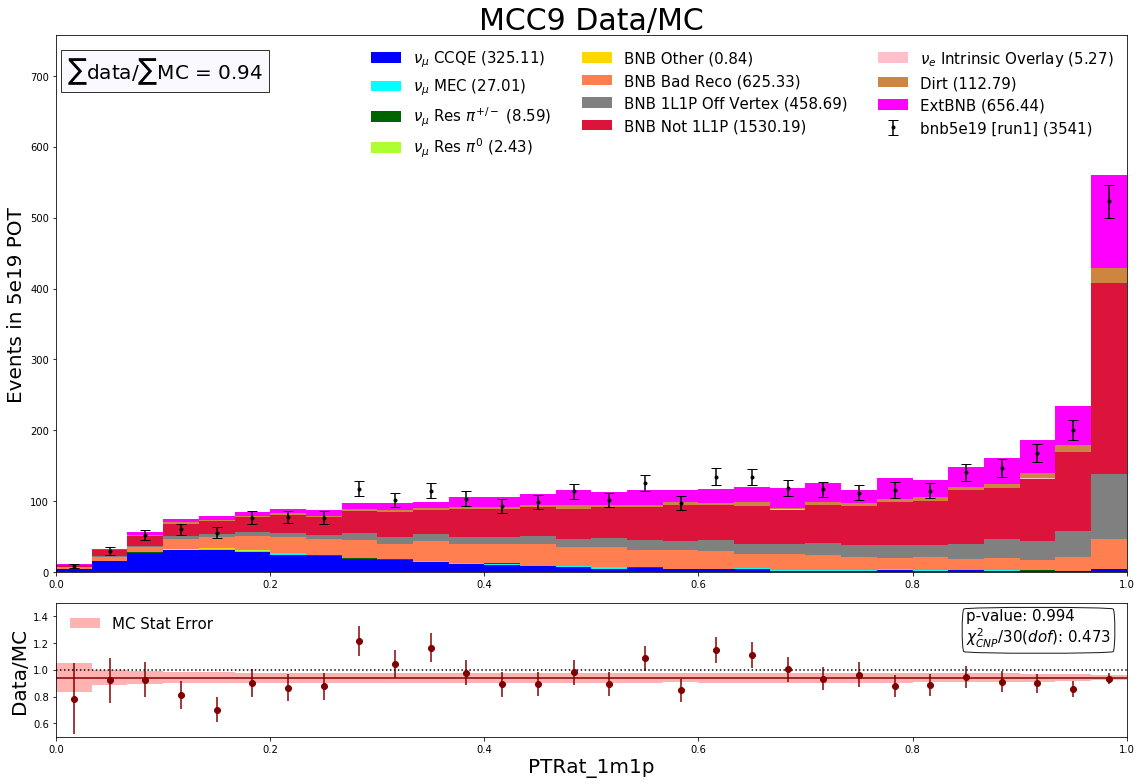

In [25]:
vartest = 'PTRat_1m1p'
varname = vartest
myrange = (0,1)

distplot_wratio(vartest,nbins,myrange,sampleHists,run1Hist,varname,normshift=.94)

Events: 3541.0
Min Bin ct (data): 0.0
Events: 3541.0
Min Bin ct (data): 0.0
Events: 3541.0
Min Bin ct (data): 22.0


KeyboardInterrupt: 

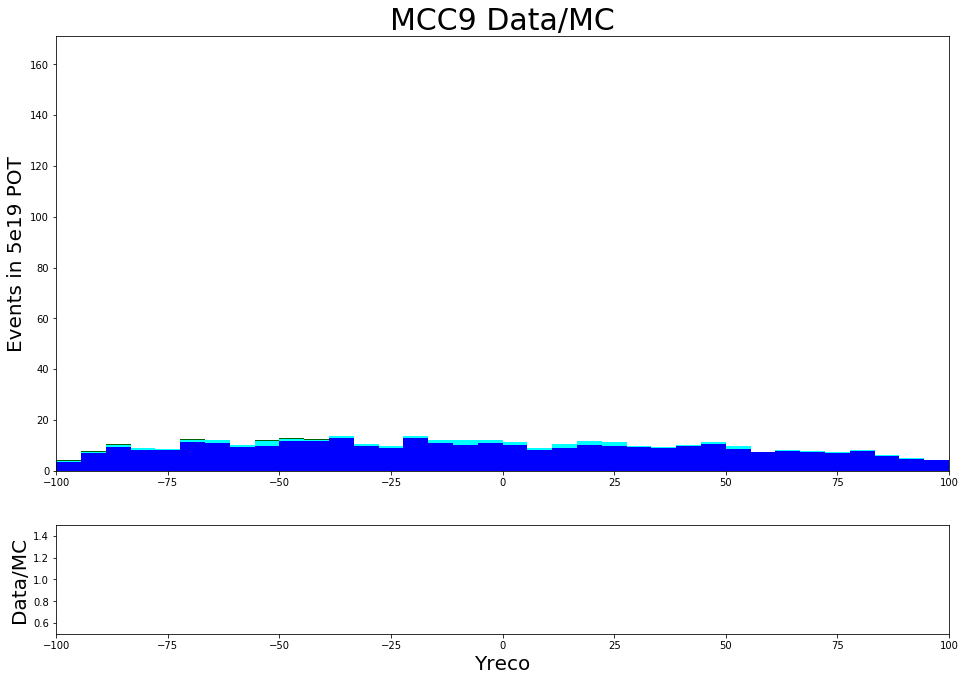

In [31]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
varlist = []

varlist.append(distVar('CosBkgScore',(-10,10)))
varlist.append(distVar('run',(4900,8000)))
varlist.append(distVar('Xreco',(15,240)))
varlist.append(distVar('Yreco',(-100,100)))
varlist.append(distVar('Zreco',(0,1020)))
varlist.append(distVar('FailedBoost',(0,1)))
varlist.append(distVar('Good3DReco',(0,1)))
varlist.append(distVar('Eta',(0,.8)))
varlist.append(distVar('OpenAng',(.5,np.pi)))
varlist.append(distVar('Thetas',(0,2*np.pi)))
varlist.append(distVar('Phis',(0,2*np.pi)))
varlist.append(distVar('ChargeNearTrunk',(0,800)))
varlist.append(distVar('CCQEEnergyShift_1m1p',(0,5)))
varlist.append(distVar('Enu_1m1p',(200,2000)))
varlist.append(distVar('PhiT_1m1p',(0,np.pi)))
varlist.append(distVar('AlphaT_1m1p',(0,np.pi)))
varlist.append(distVar('PT_1m1p',(0,850)))
varlist.append(distVar('PTRat_1m1p',(0,1)))
varlist.append(distVar('BjX_1m1p',(0,2)))
varlist.append(distVar('BjY_1m1p',(0,1)))
varlist.append(distVar('Q2_1m1p',(0,6e5)))
varlist.append(distVar('Sph_1m1p',(0,4000)))
varlist.append(distVar('PzEnu_1m1p',(-1500,400)))
varlist.append(distVar('Q0_1m1p',(70,600)))
varlist.append(distVar('Q3_1m1p',(50,1000)))
varlist.append(distVar('Lepton_PhiReco',(-np.pi,np.pi)))
varlist.append(distVar('Lepton_ThetaReco',(0,np.pi)))
varlist.append(distVar('Lepton_TrackLength',(5,200)))
varlist.append(distVar('Muon_Edep',(20,600)))
varlist.append(distVar('Proton_PhiReco',(-np.pi,np.pi)))
varlist.append(distVar('Proton_ThetaReco',(0,np.pi)))
varlist.append(distVar('Proton_TrackLength',(5,150)))
varlist.append(distVar('Proton_Edep',(50,500)))


dumpbins = 36
dumphole = 'run1_presel_nodupes_apr7_normshift' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlist:
    fig,ax0 = distplot_wratio(dist.myname,dumpbins,dist.myrange,sampleHists,run1Hist,dist.myname,normshift=.9)
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

In [32]:
# Load up BDT weights to apply to our samples
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_WC_apr1.pickle','rb') as handle: cosmicBDT,nubkgBDT = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
    
vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']

myvars = vars_cos_allofem
s_nubdtname = 'NuBkgScore'
s_cosbdtname = 'CosmicBkgScore'
for i in range(len(sampleHists)):
    sampleHists[i]._df.insert(0,s_nubdtname,nubkgBDT.predict(sampleHists[i]._df[myvars].values.tolist(),output_margin=True))
    sampleHists[i]._df.insert(0,s_cosbdtname,cosmicBDT.predict(sampleHists[i]._df[myvars].values.tolist(),output_margin=True))
    
    
run1Hist._df.insert(0,s_nubdtname,nubkgBDT.predict(run1Hist._df[myvars].values.tolist(),output_margin=True))
run3Hist._df.insert(0,s_nubdtname,nubkgBDT.predict(run3Hist._df[myvars].values.tolist(),output_margin=True))
run1Hist._df.insert(0,s_cosbdtname,cosmicBDT.predict(run1Hist._df[myvars].values.tolist(),output_margin=True))
run3Hist._df.insert(0,s_cosbdtname,cosmicBDT.predict(run3Hist._df[myvars].values.tolist(),output_margin=True))

Events: 3507.0
Min Bin ct (data): 25.0


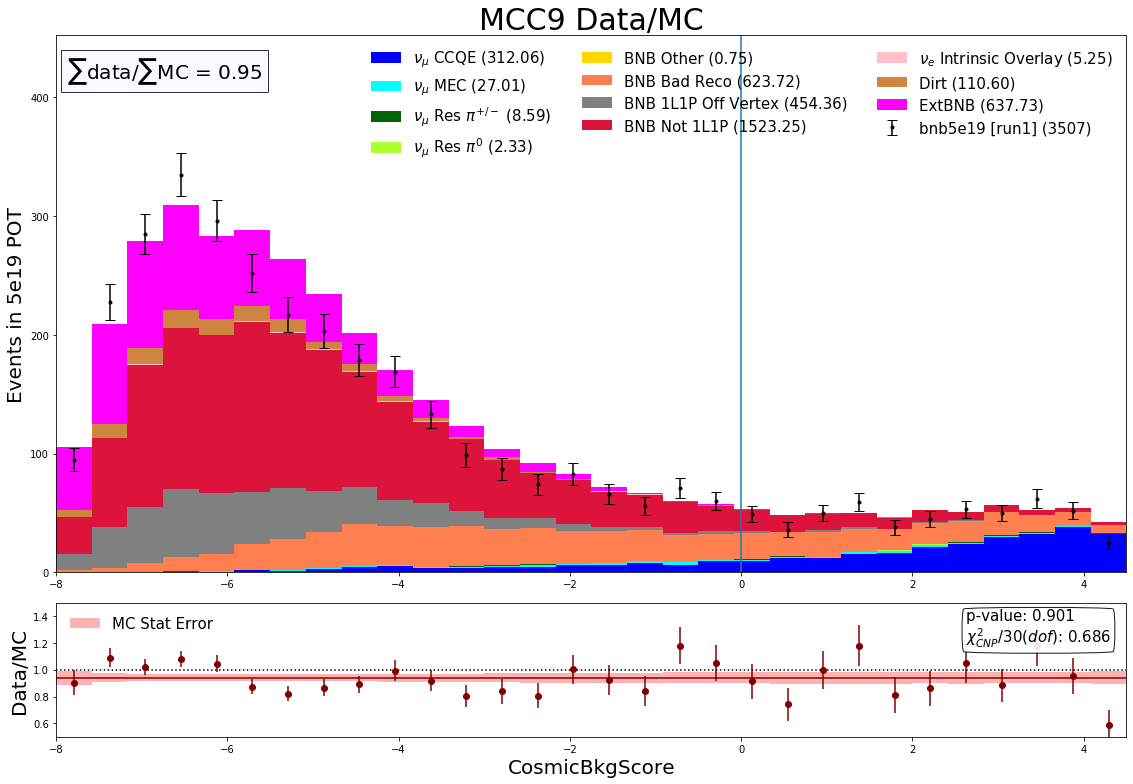

In [33]:
vartest = 'CosmicBkgScore'
varname = vartest
myrange = (-8,4.5)

fig,ax0 = distplot_wratio(vartest,nbins,myrange,sampleHists,run1Hist,varname,normshift=.94)
ax0.axvline(0)

Events: 3443.0
Min Bin ct (data): 27.0


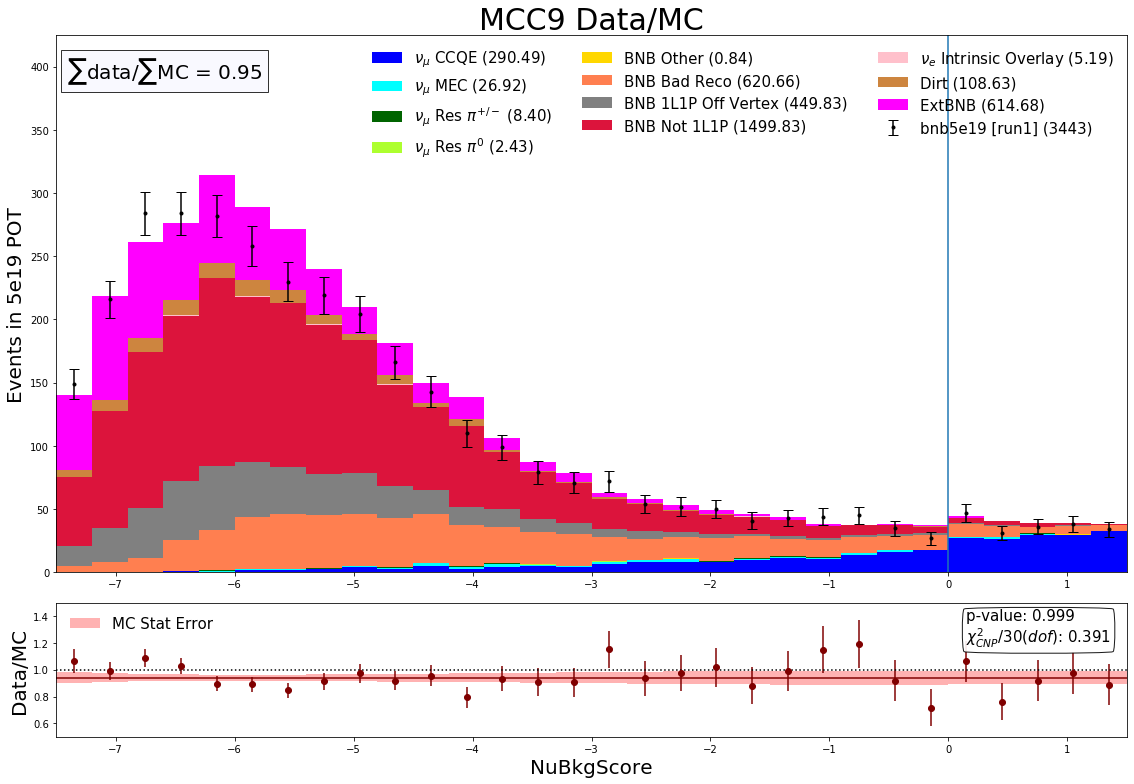

In [34]:
vartest = 'NuBkgScore'
varname = vartest
myrange = (-7.5,1.5)

fig,ax0=distplot_wratio(vartest,nbins,myrange,sampleHists,run1Hist,varname,normshift=.94)
ax0.axvline(0)

# Apply cuts

In [35]:
bdtcuts = 'CosmicBkgScore > 0 and NuBkgScore > 0'

s_cuts = bdtcuts

s_ano_simple_w = wrap('Precuts and '+s_cuts,28)
s_ano_simple = '' 
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [36]:
numuHistsSel = []

for i in range(len(numuHists)):
    numuHistsSel.append(numuHists[i].applycut(s_cuts))

run1HistSel = run1Hist.applycut(s_cuts)
run3HistSel = run3Hist.applycut(s_cuts)

errlabel = 'Flux Sys Only'
nbins = 12

NameError: name 'copy' is not defined

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Events: 212.0
Min Bin ct (data): 0.0


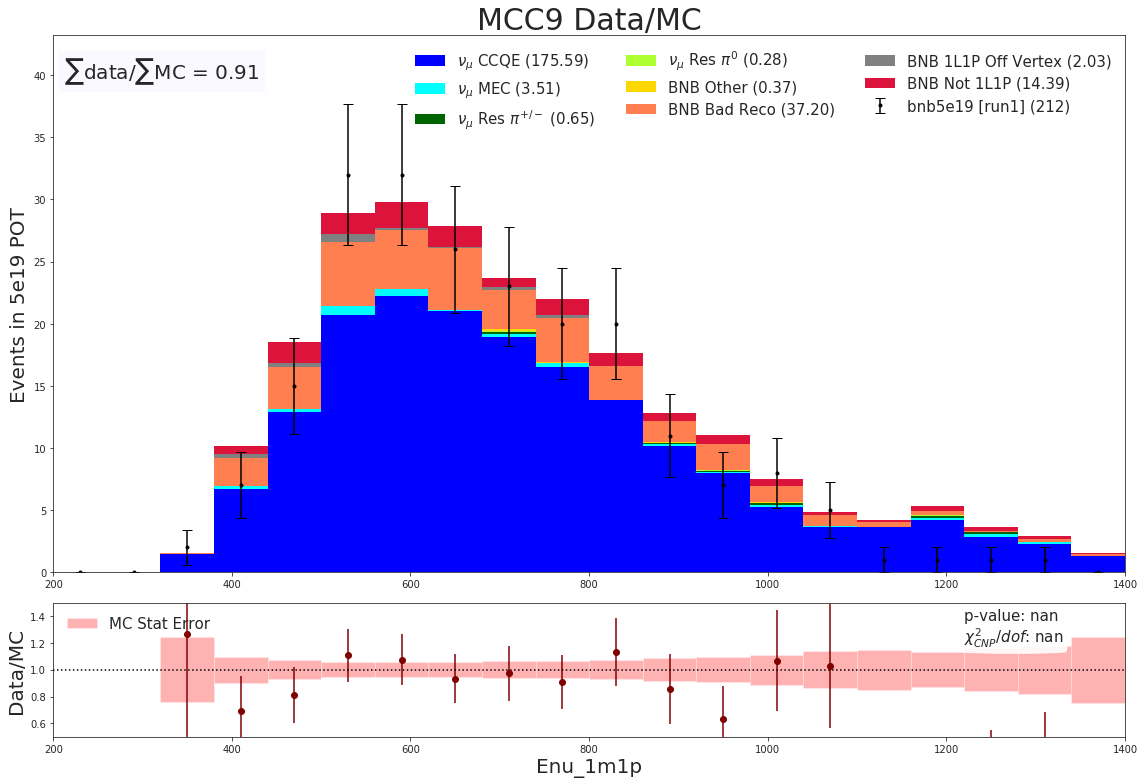

In [124]:
vartest = 'Enu_1m1p'
varname = vartest
myrange = (200,1400)
#cov = np.genfromtxt('../data/CovMatrices/covar_postsel_set1__nu_energy_reco.txt',delimiter=',')
legpos = 0

fig,ax0 = distplot_wratio(vartest,20,myrange,numuHistsSel,run1HistSel,varname)
ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Events: 217.0
Min Bin ct (data): 0.0


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide


Events: 217.0
Min Bin ct (data): 0.0
Events: 217.0
Min Bin ct (data): 10.0
Events: 217.0
Min Bin ct (data): 9.0
Events: 217.0
Min Bin ct (data): 8.0
Events: 217.0
Min Bin ct (data): 0.0
Events: 217.0
Min Bin ct (data): 0.0
Events: 209.0
Min Bin ct (data): 4.0
Events: 215.0
Min Bin ct (data): 2.0
Events: 217.0
Min Bin ct (data): 0.0
Events: 213.0
Min Bin ct (data): 1.0
Events: 206.0
Min Bin ct (data): 3.0
Events: 216.0
Min Bin ct (data): 1.0
Events: 188.0
Min Bin ct (data): 0.0
Events: 173.0
Min Bin ct (data): 0.0
Events: 163.0
Min Bin ct (data): 0.0
Events: 217.0
Min Bin ct (data): 0.0
Events: 205.0
Min Bin ct (data): 3.0
Events: 214.0
Min Bin ct (data): 1.0
Events: 217.0
Min Bin ct (data): 11.0


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Events: 214.0
Min Bin ct (data): 3.0
Events: 211.0
Min Bin ct (data): 2.0
Events: 209.0
Min Bin ct (data): 4.0
Events: 212.0
Min Bin ct (data): 6.0
Events: 190.0
Min Bin ct (data): 6.0
Events: 180.0
Min Bin ct (data): 1.0
Events: 217.0
Min Bin ct (data): 0.0
Events: 214.0
Min Bin ct (data): 2.0
Events: 208.0
Min Bin ct (data): 5.0
Events: 217.0
Min Bin ct (data): 7.0
Events: 215.0
Min Bin ct (data): 1.0
Events: 156.0
Min Bin ct (data): 0.0
Events: 185.0
Min Bin ct (data): 5.0
Events: 217.0
Min Bin ct (data): 5.0
Events: 215.0
Min Bin ct (data): 0.0
Events: 164.0
Min Bin ct (data): 3.0
Events: 203.0
Min Bin ct (data): 3.0


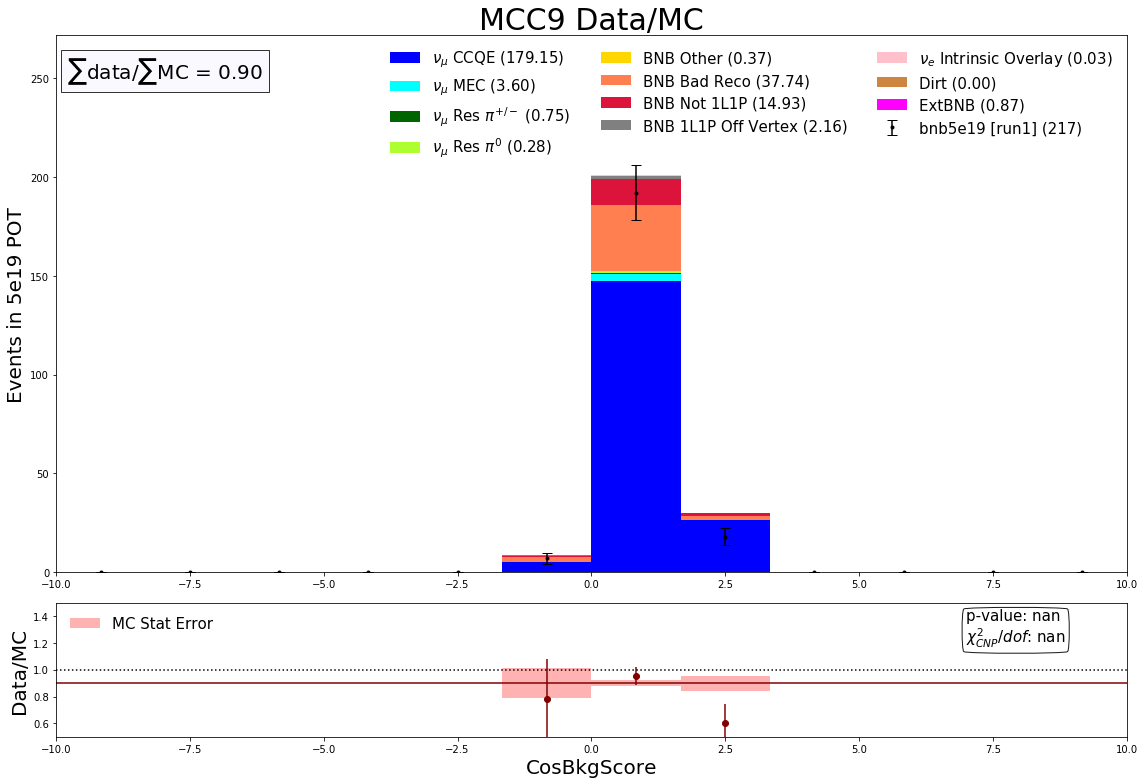

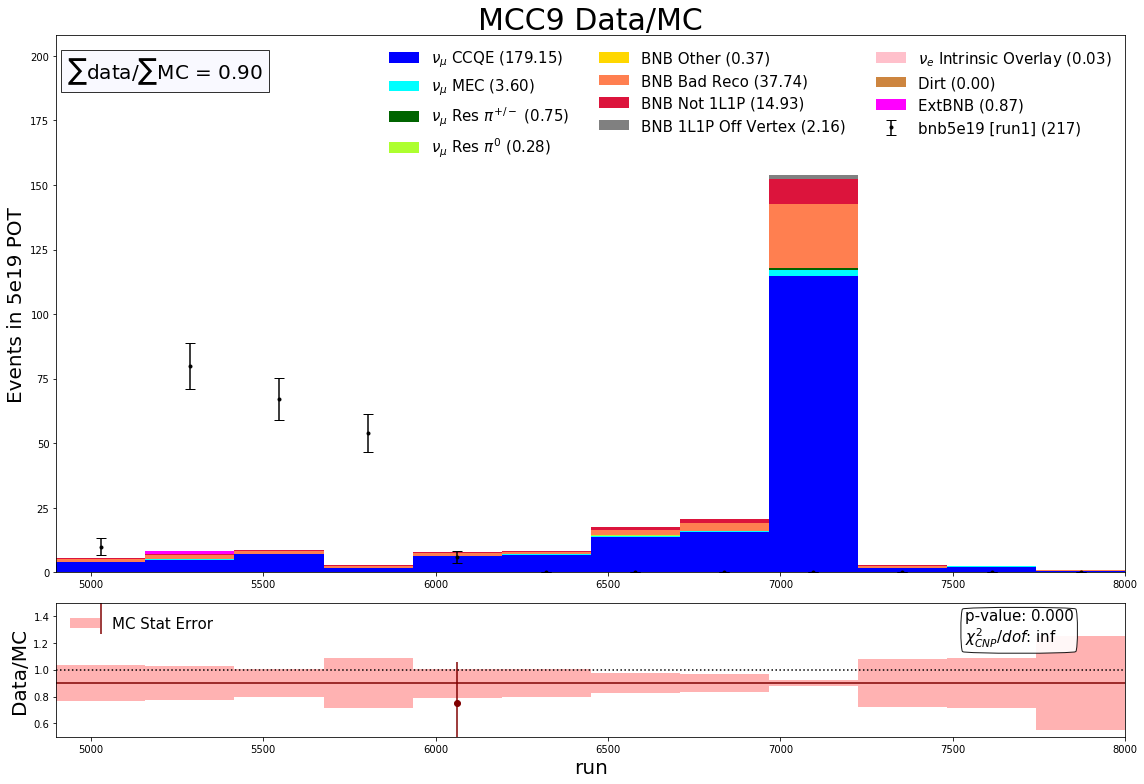

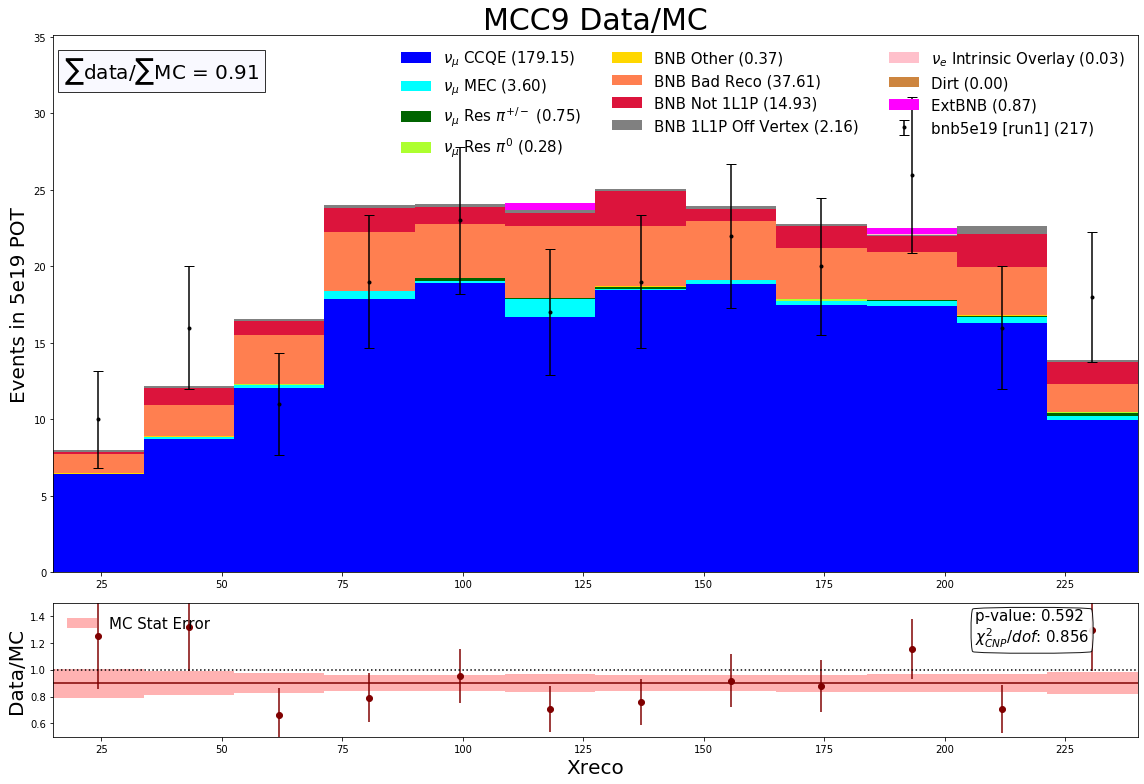

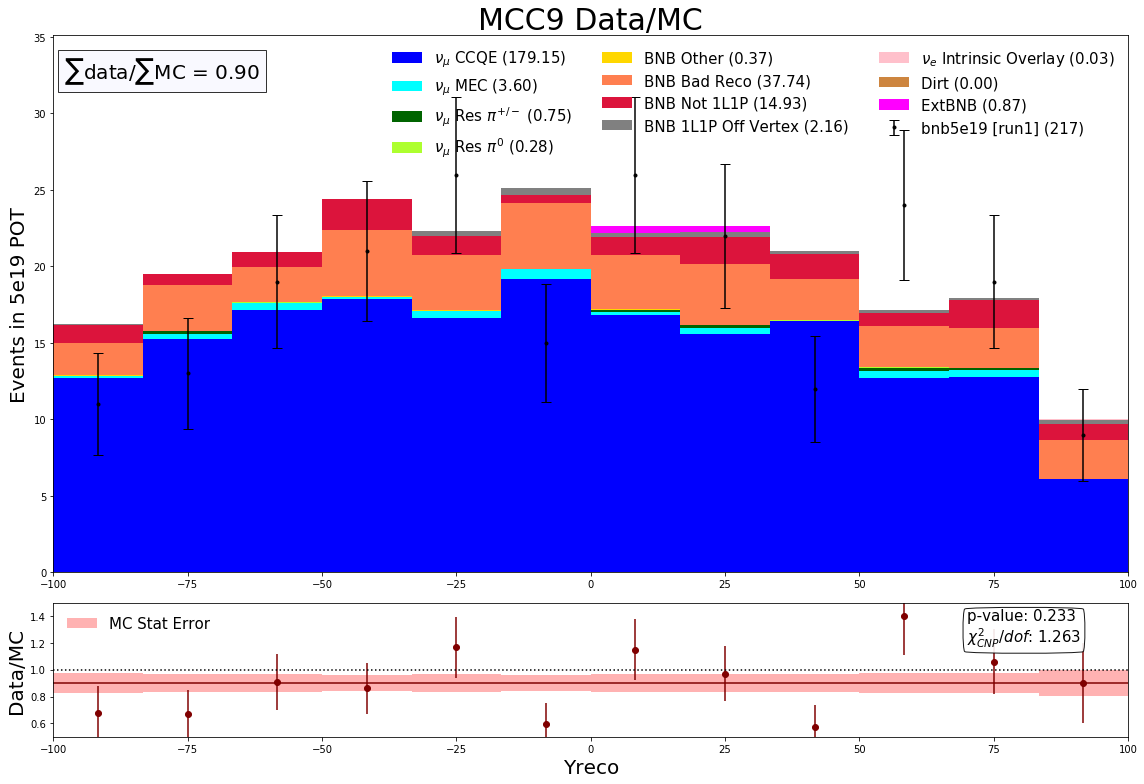

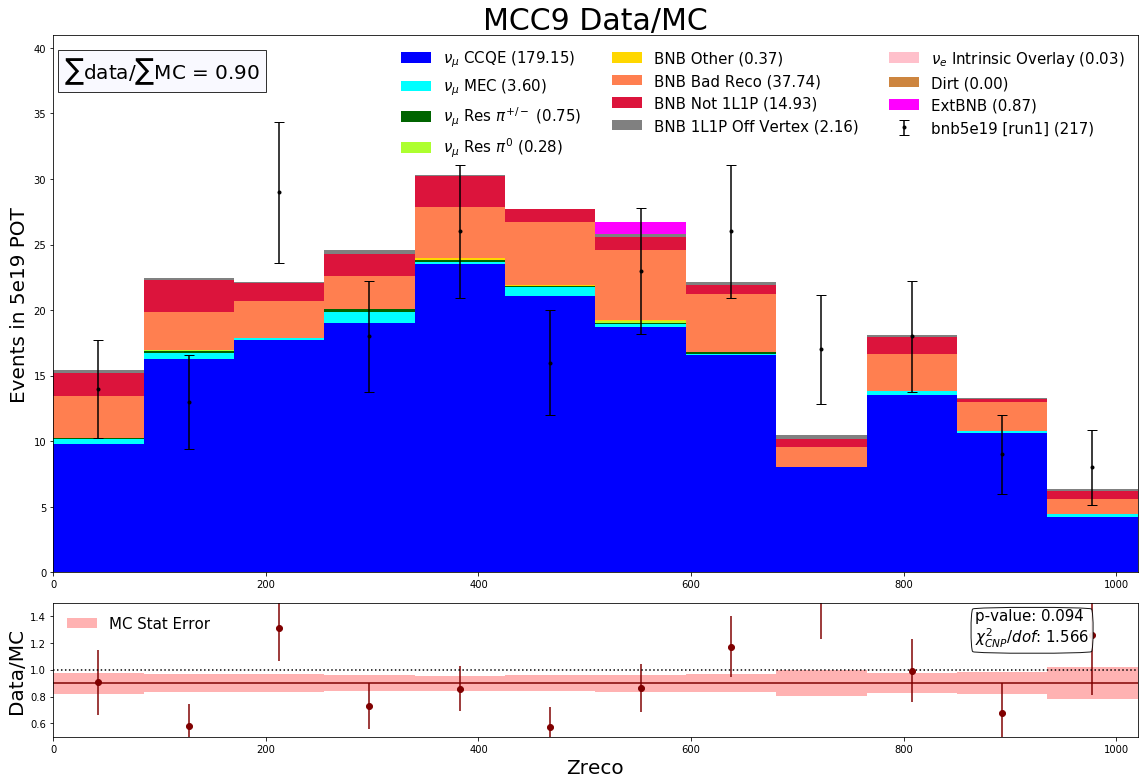

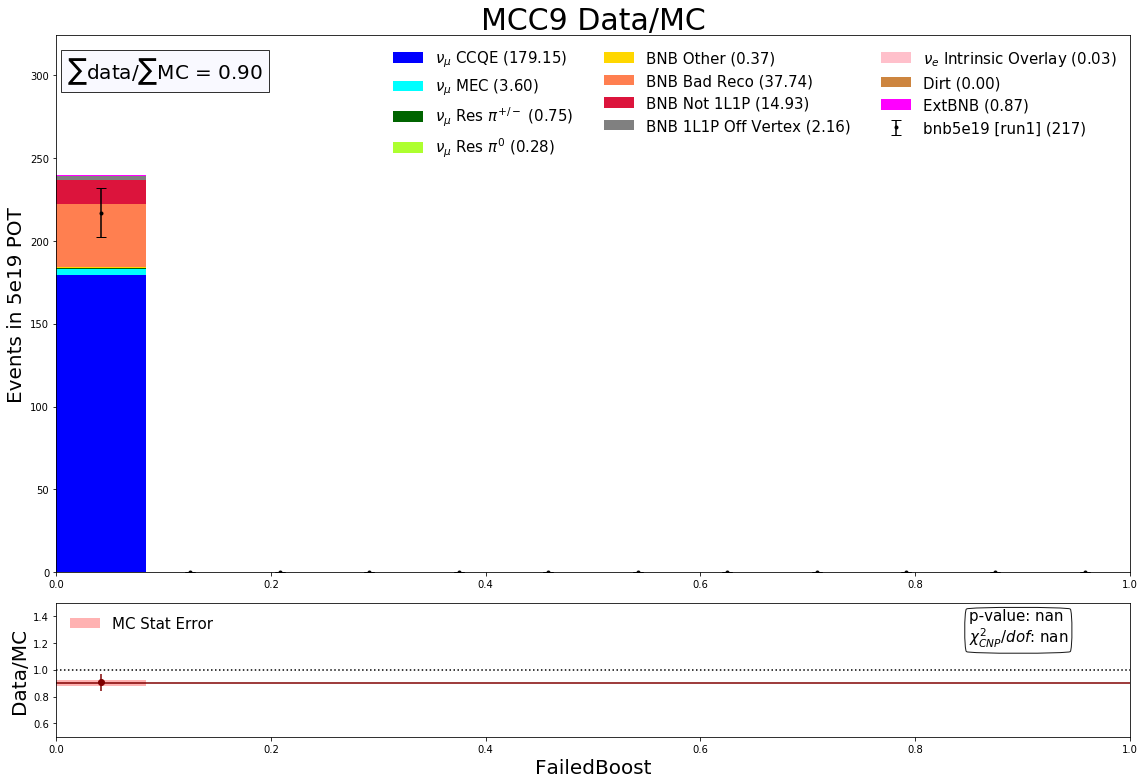

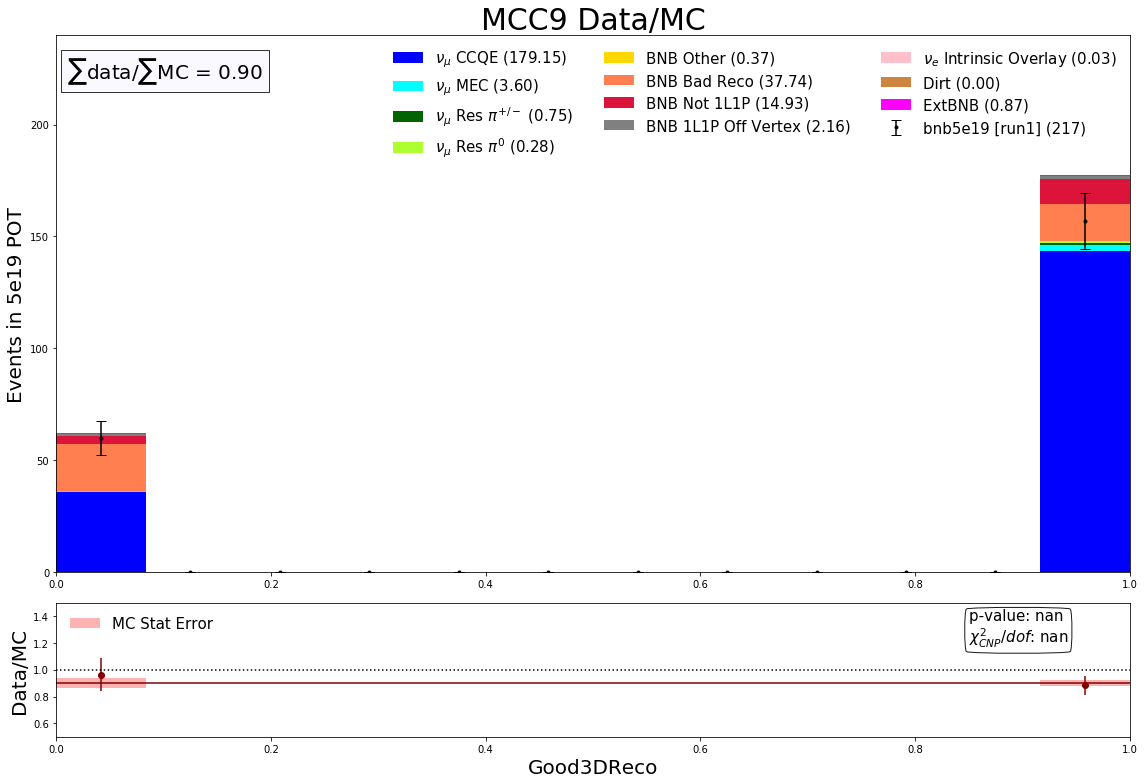

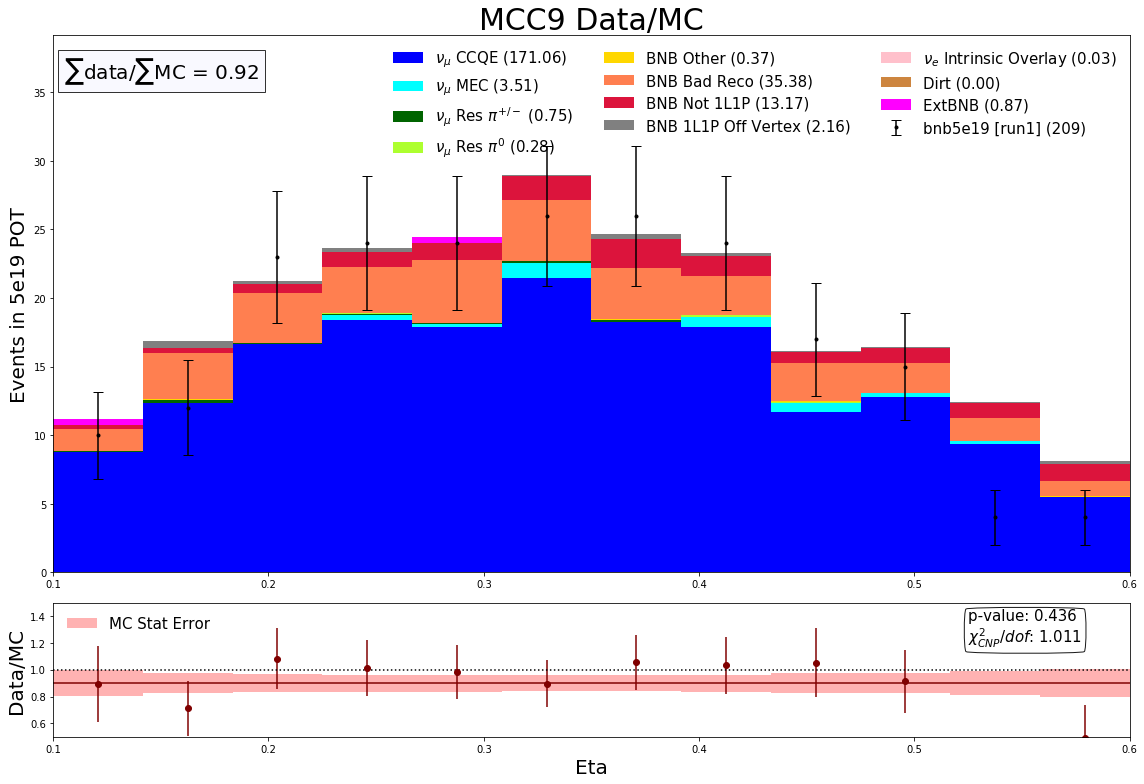

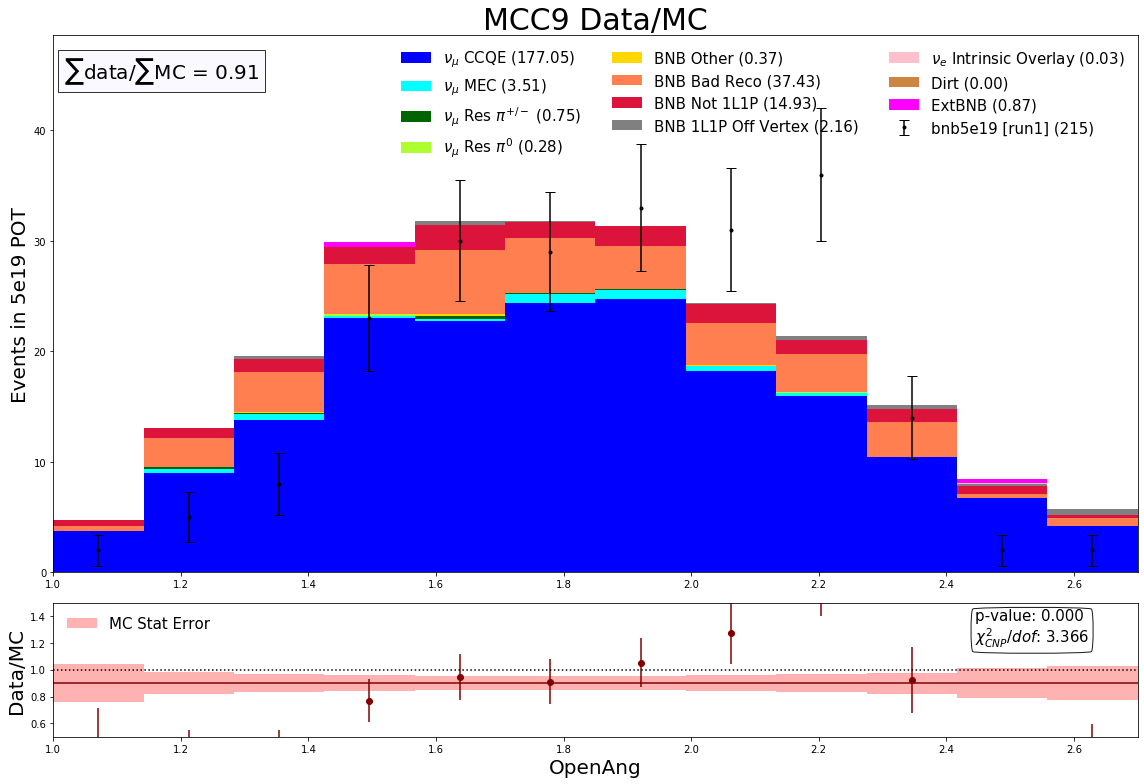

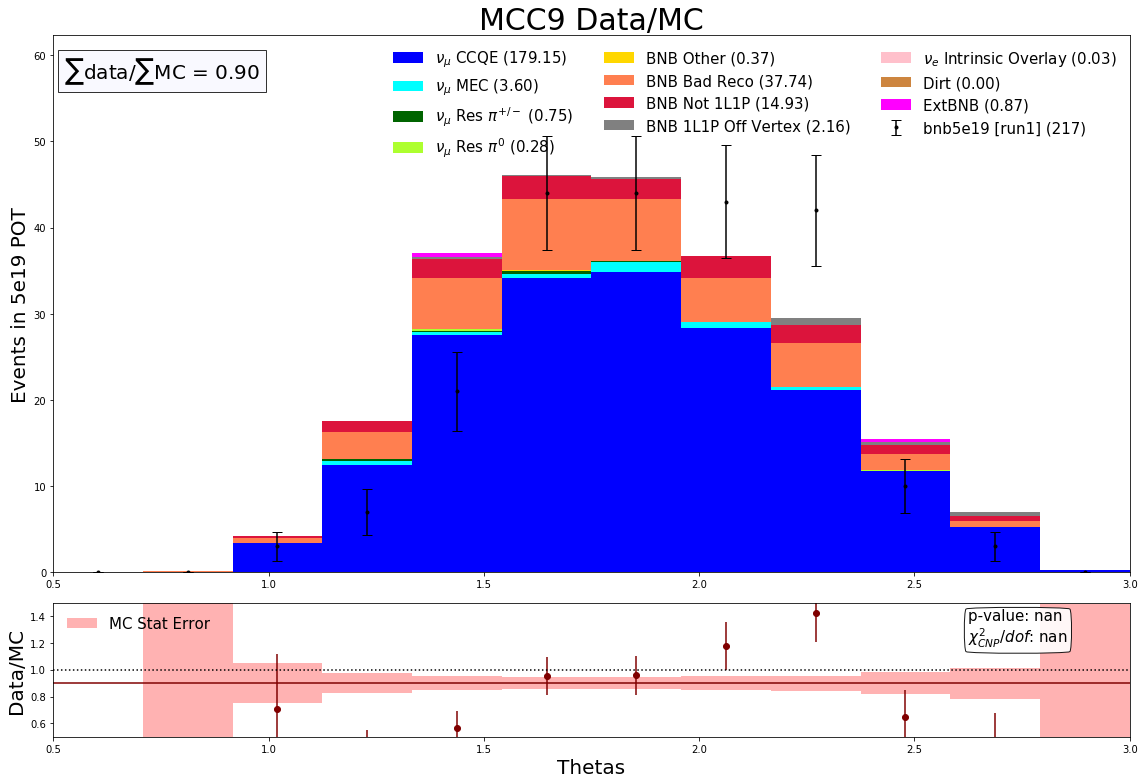

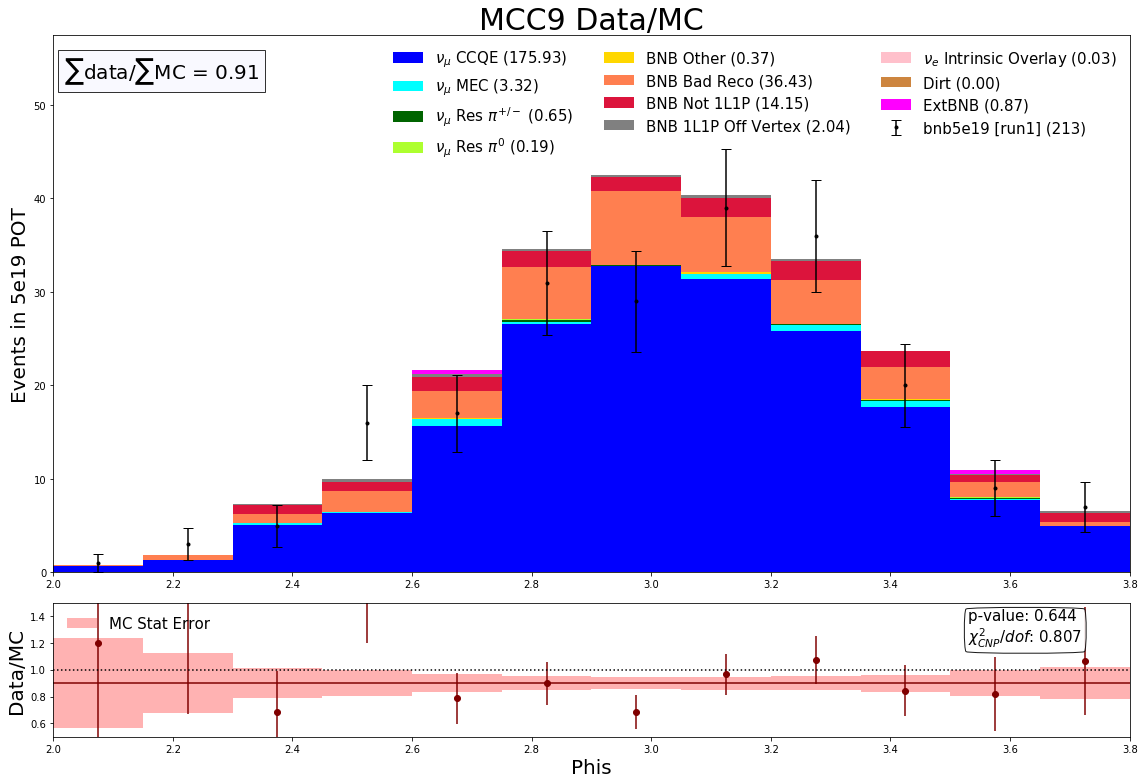

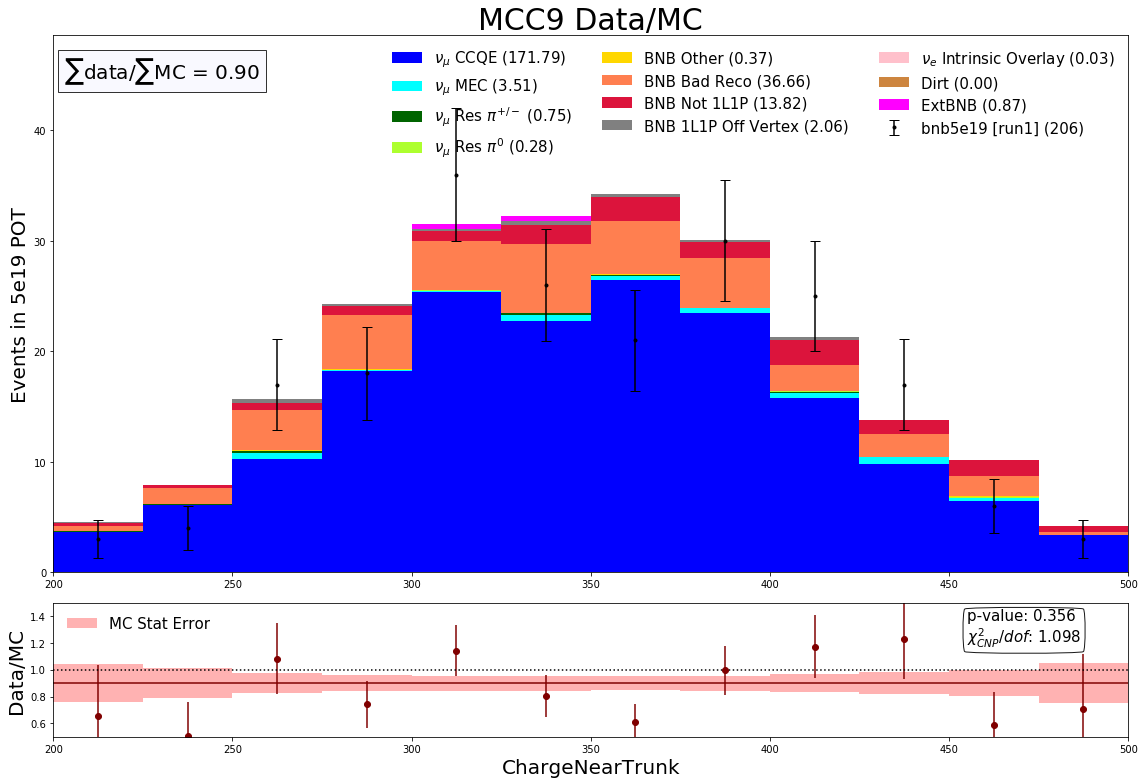

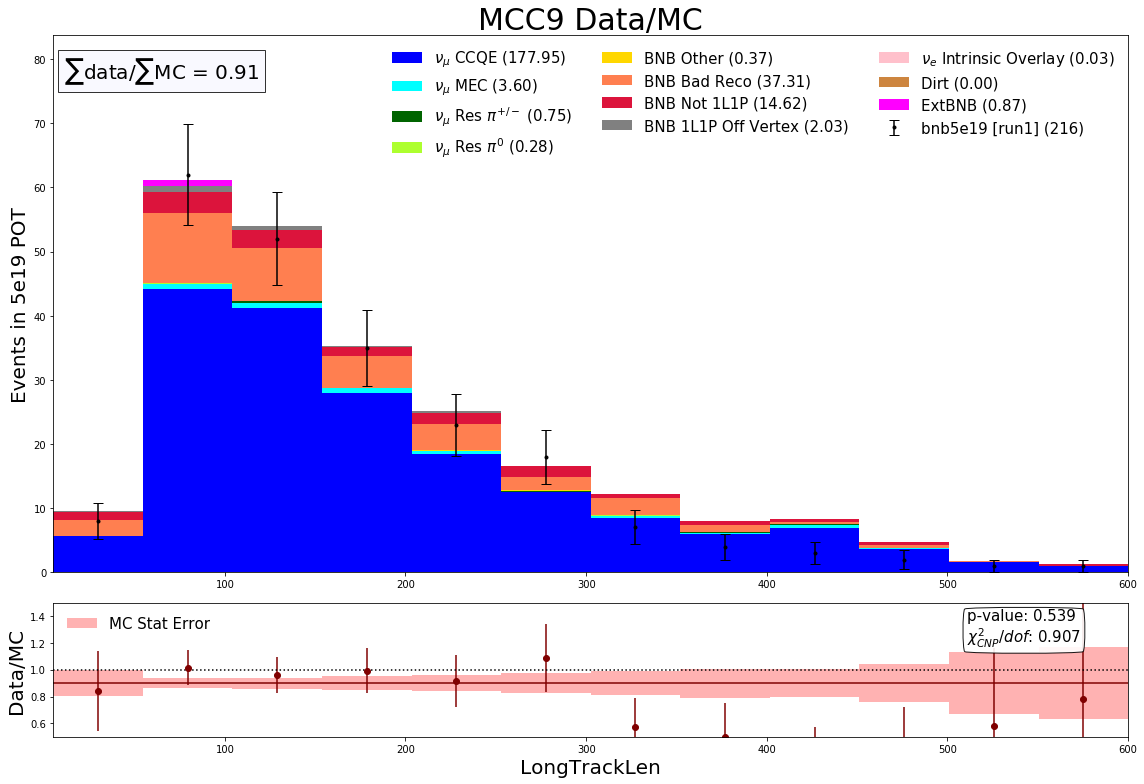

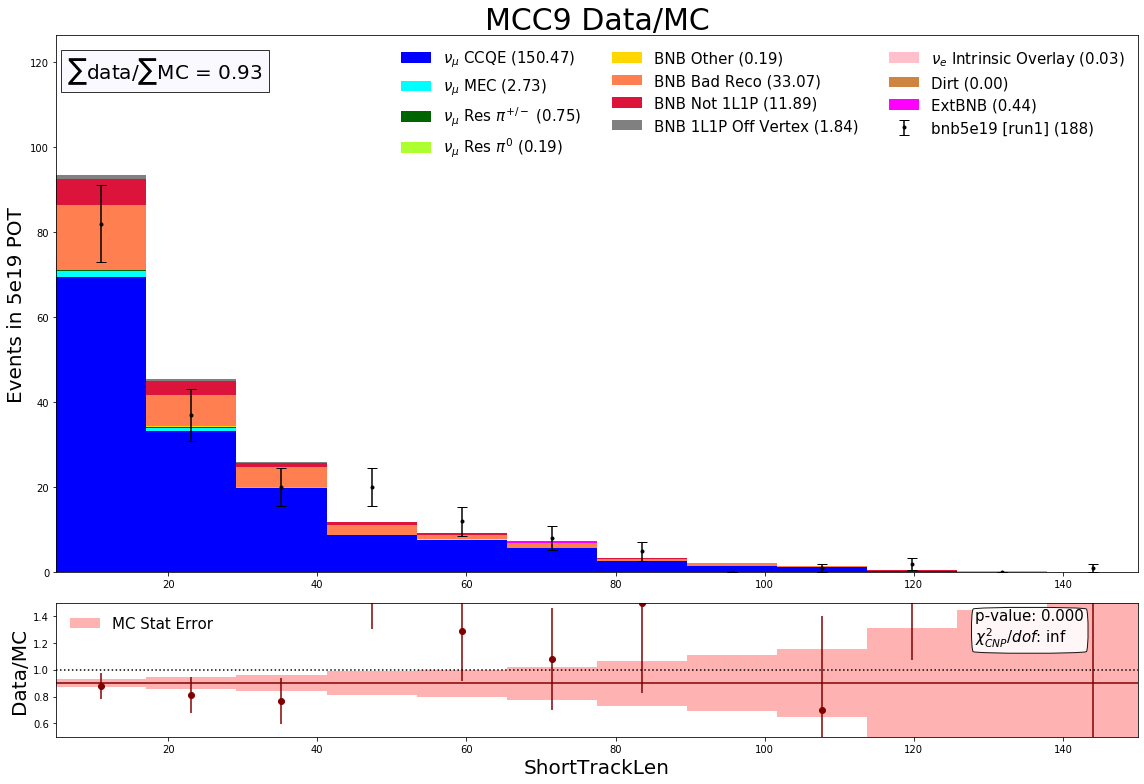

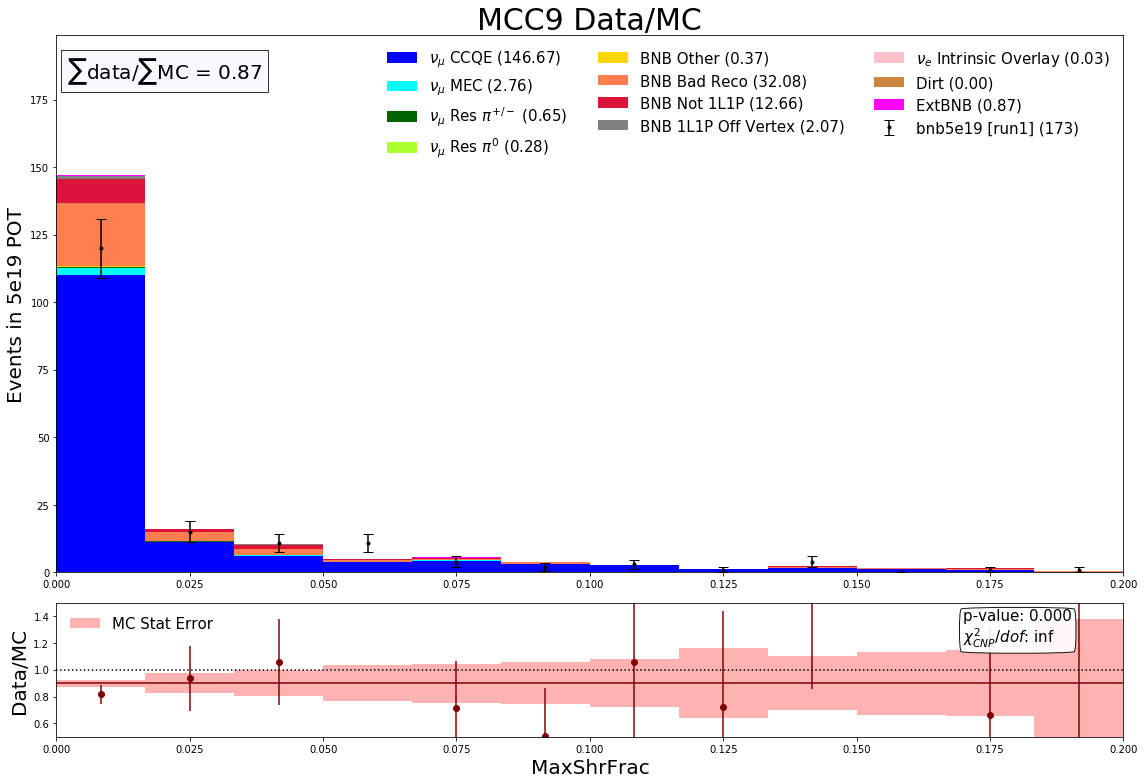

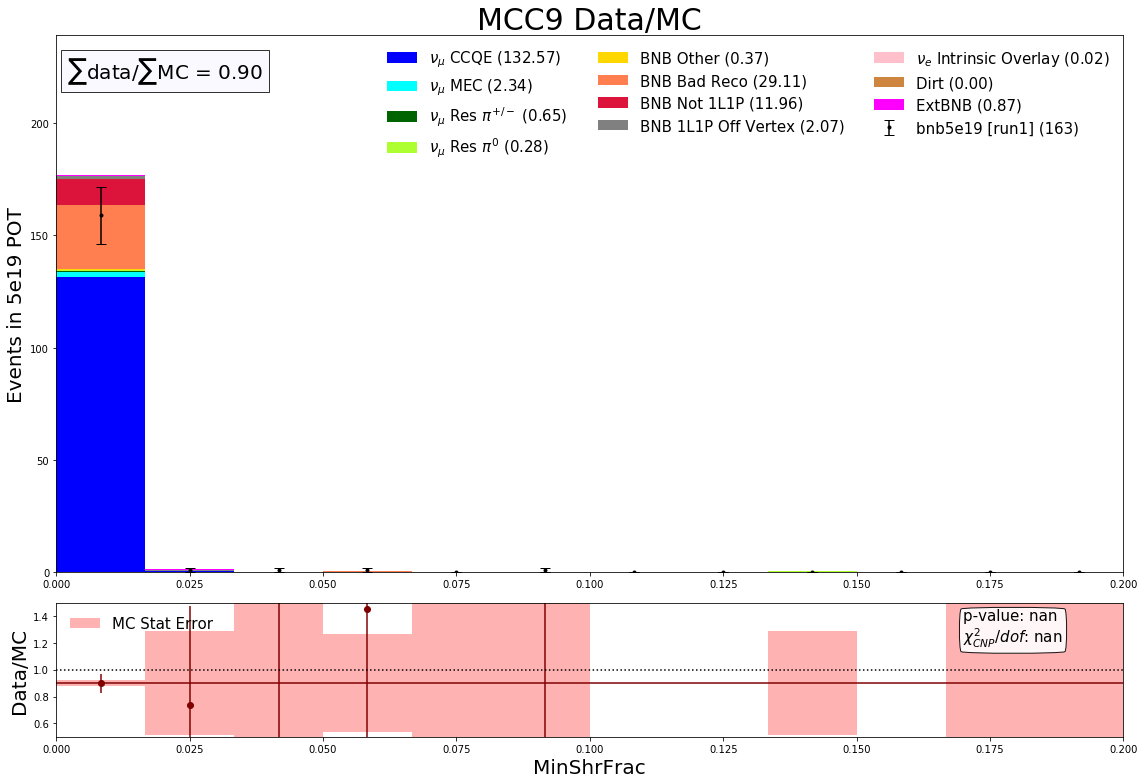

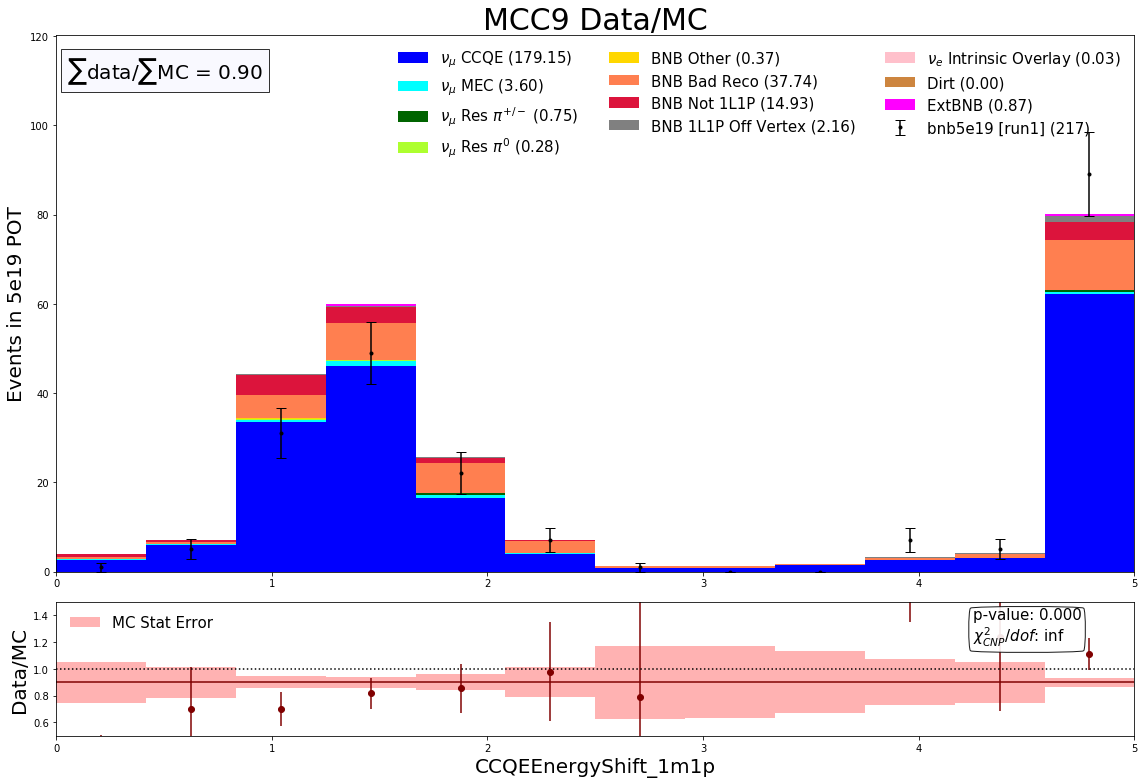

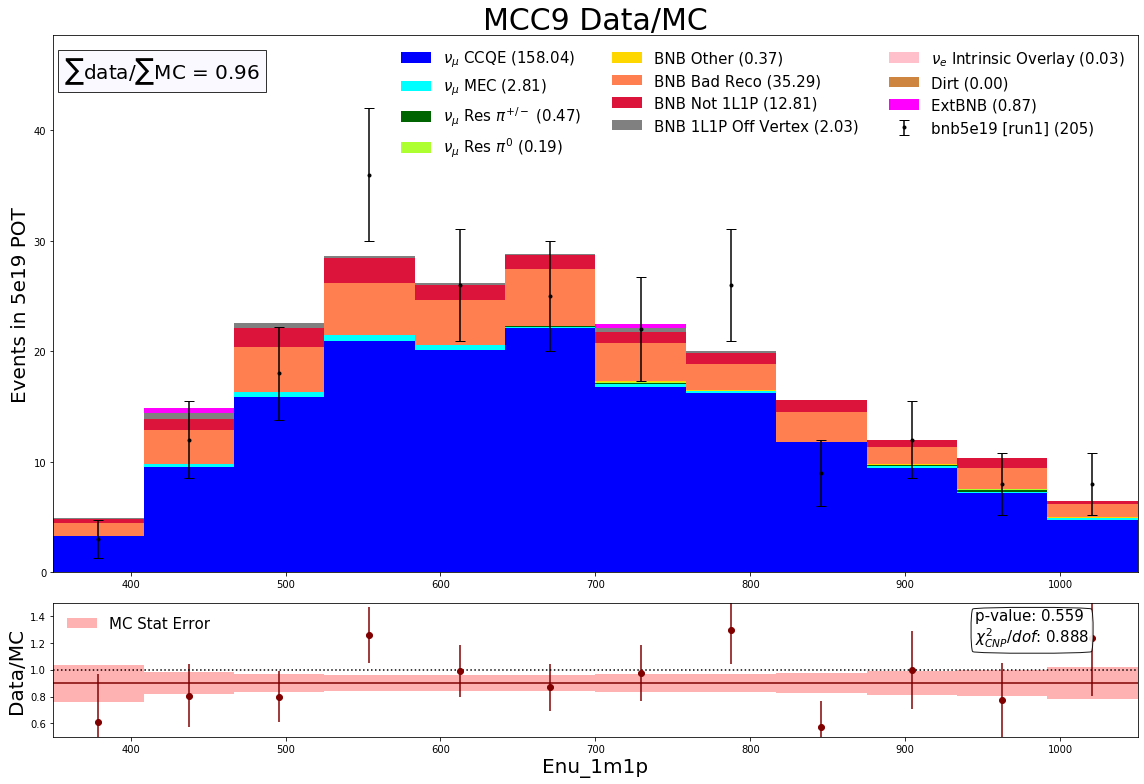

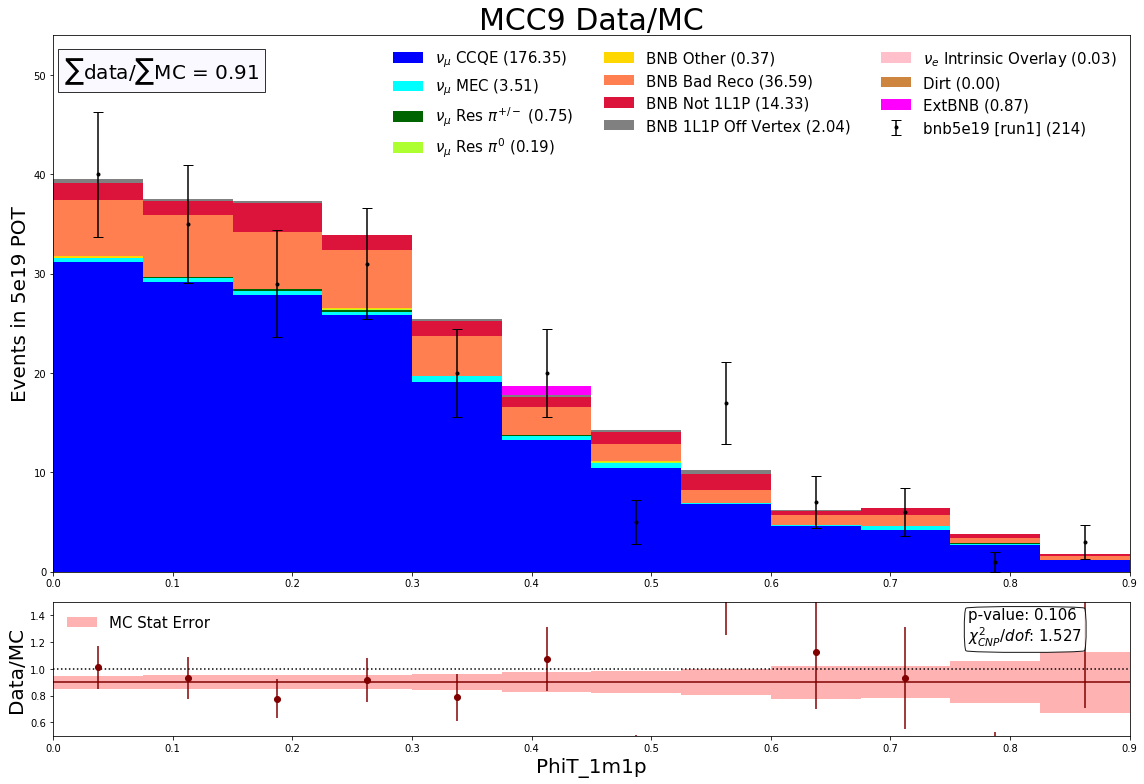

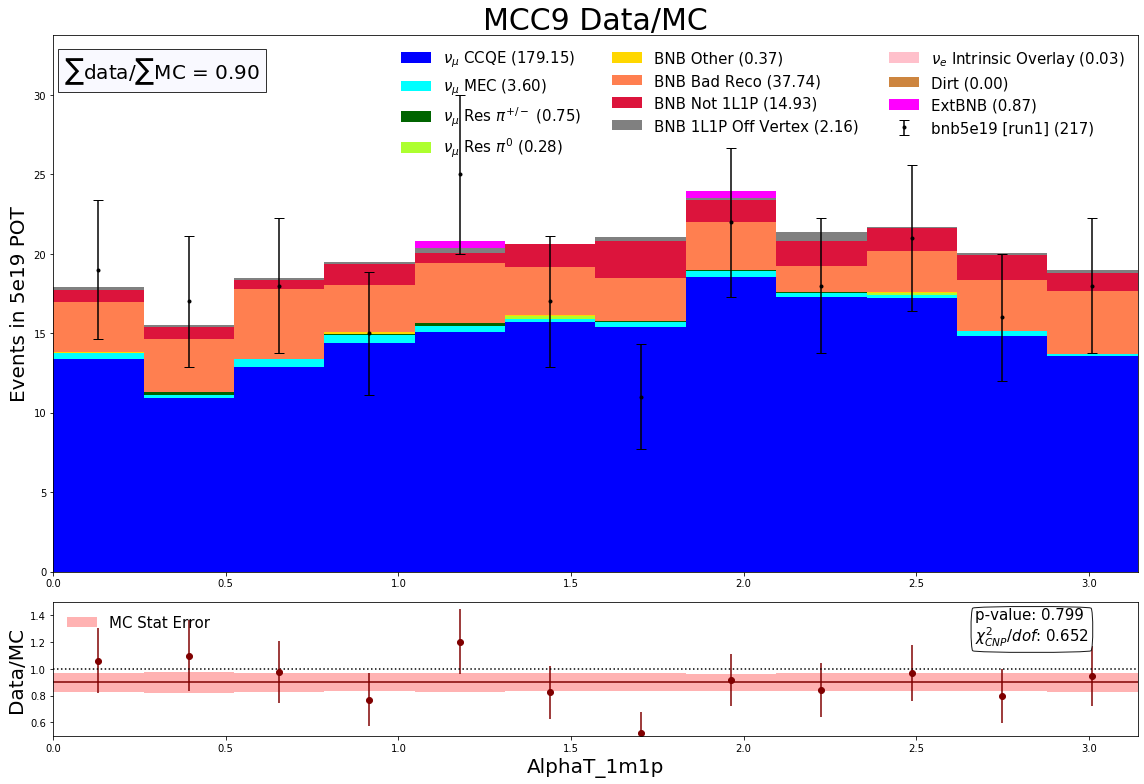

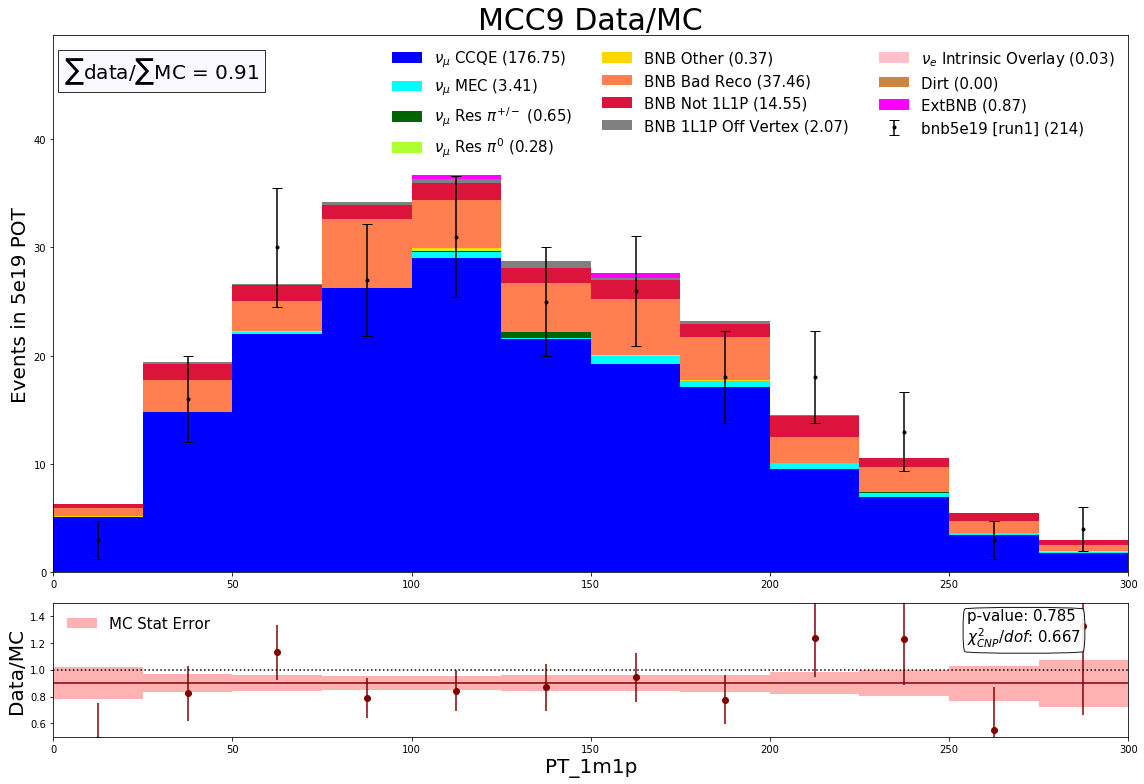

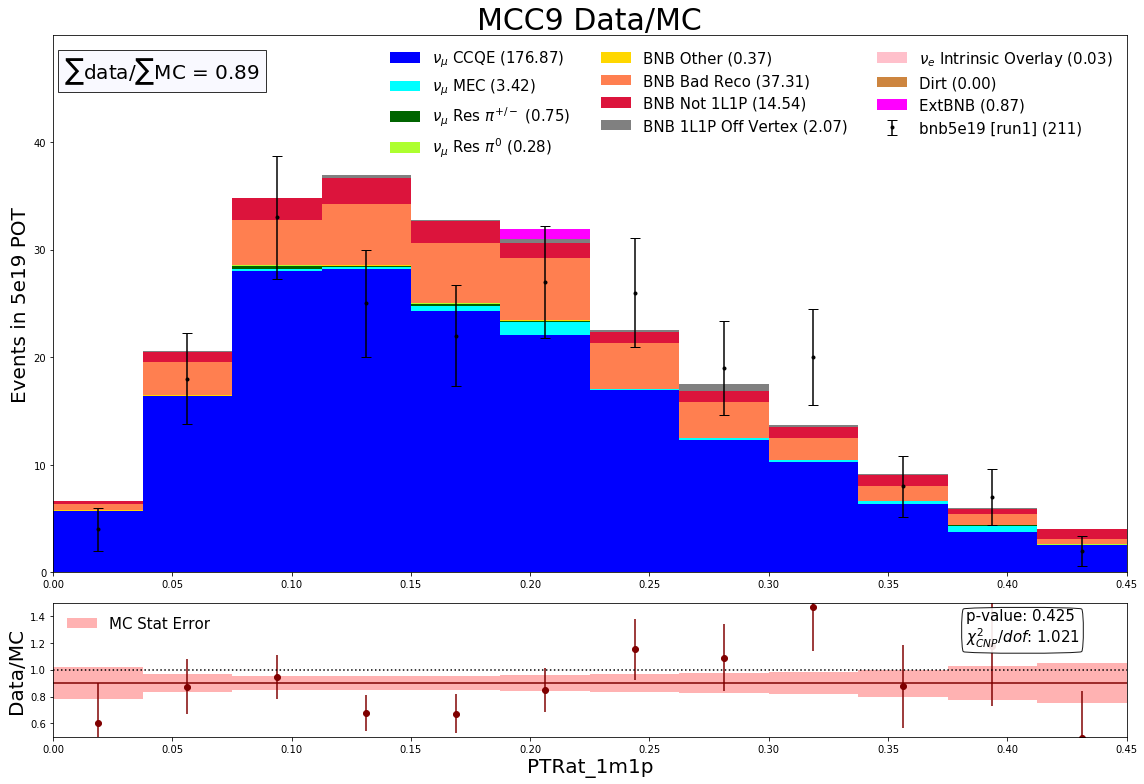

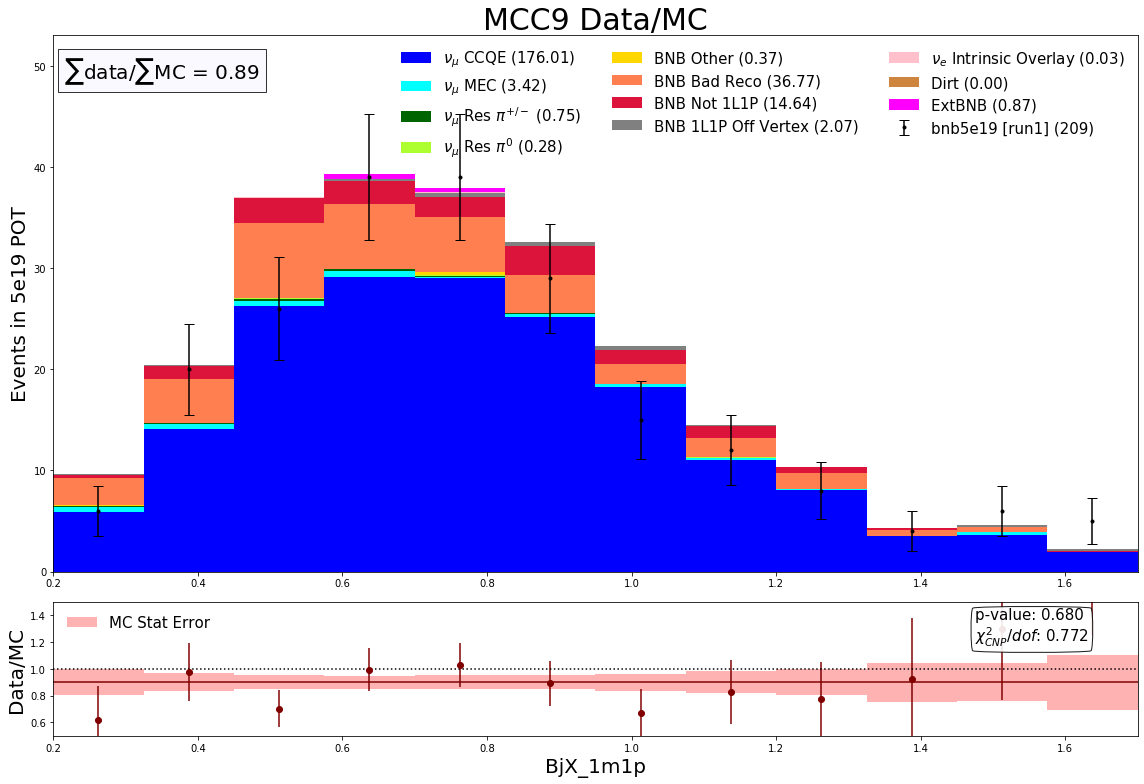

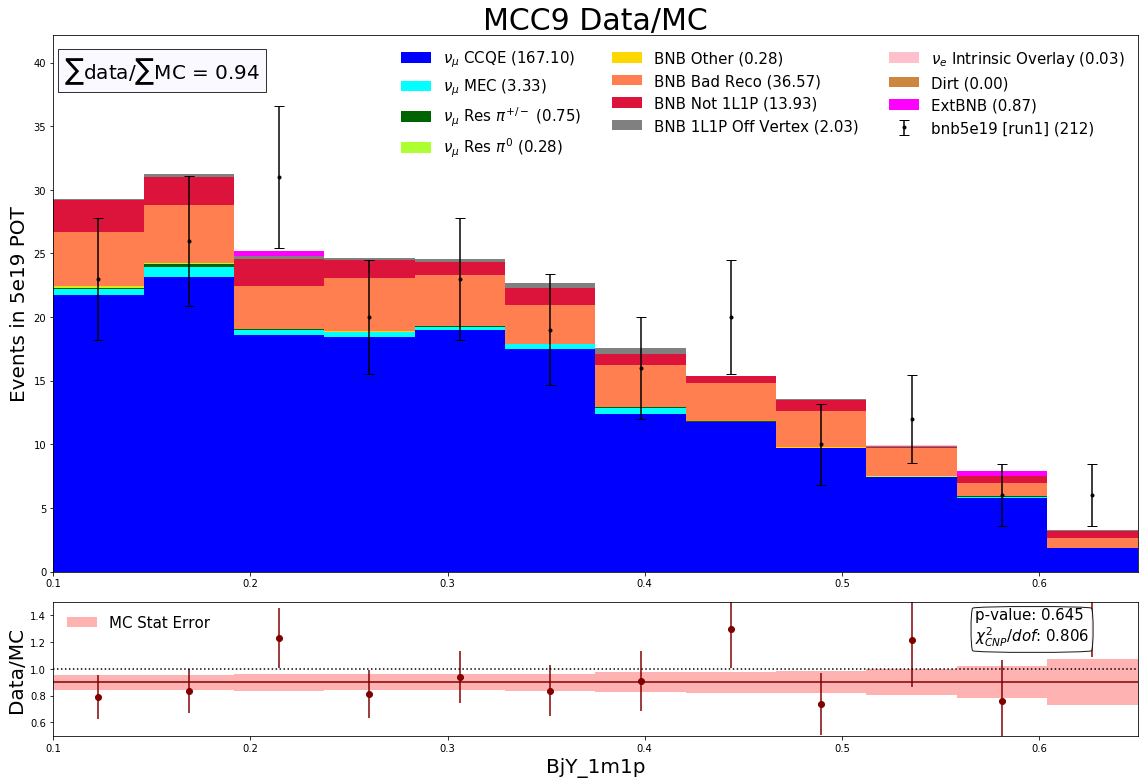

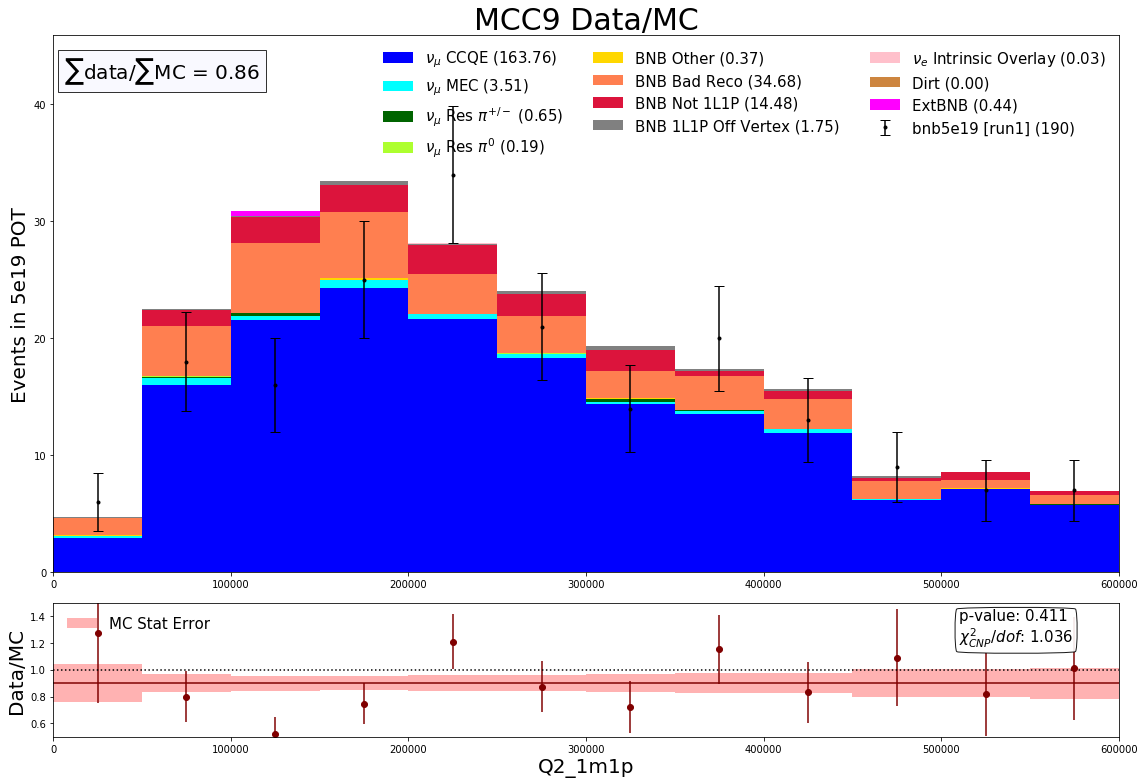

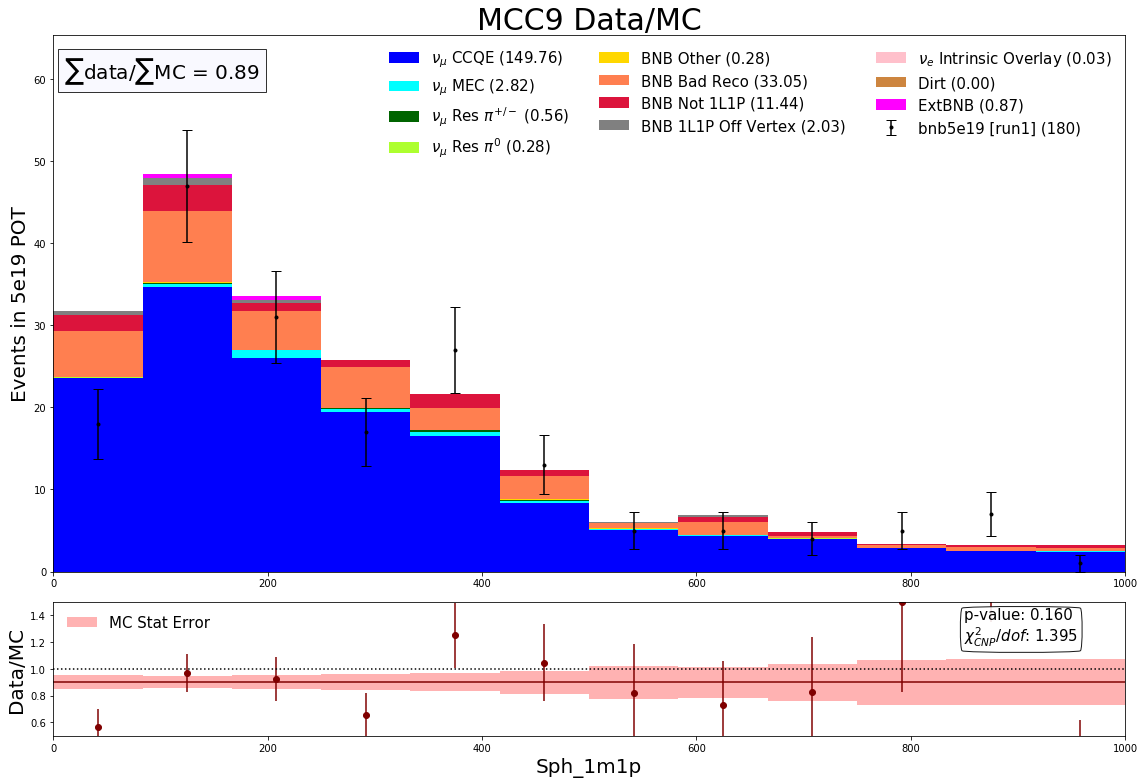

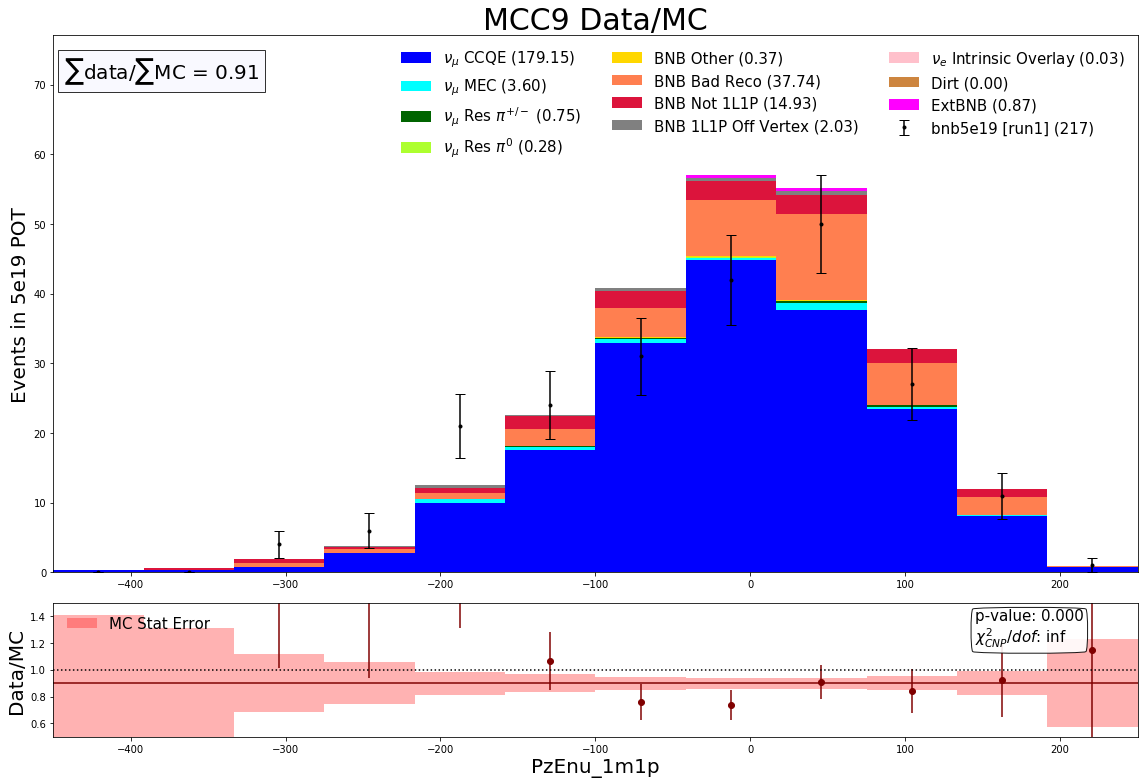

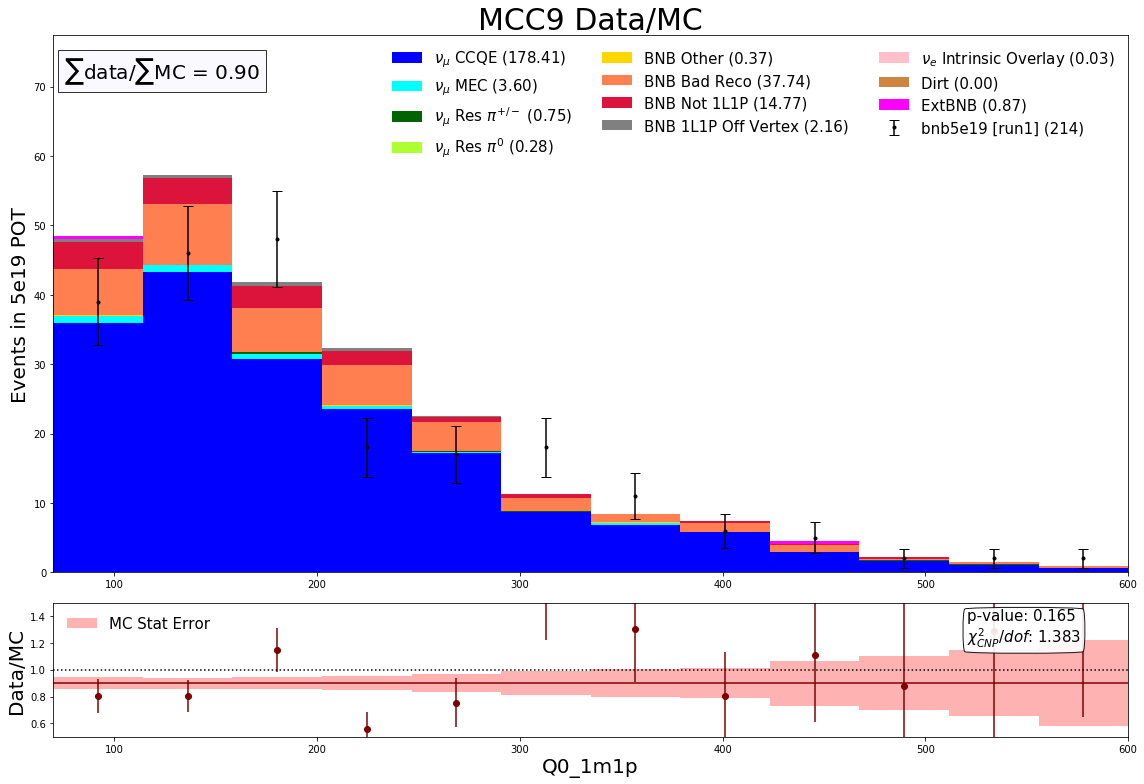

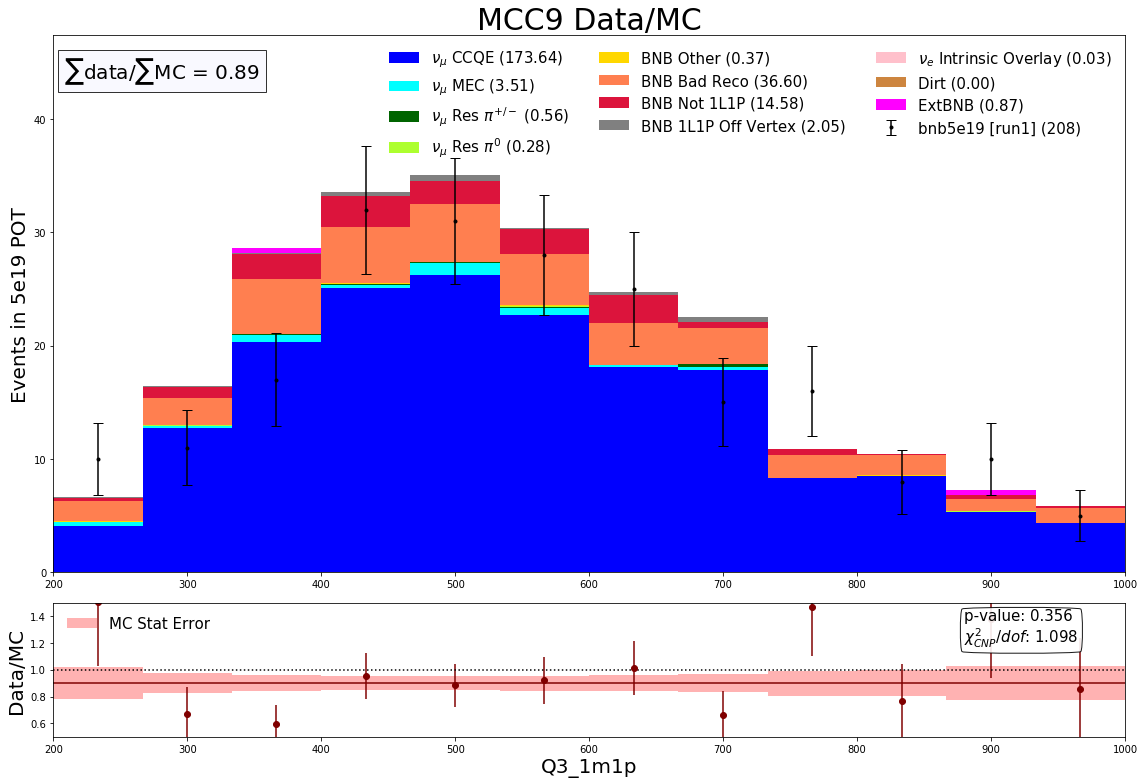

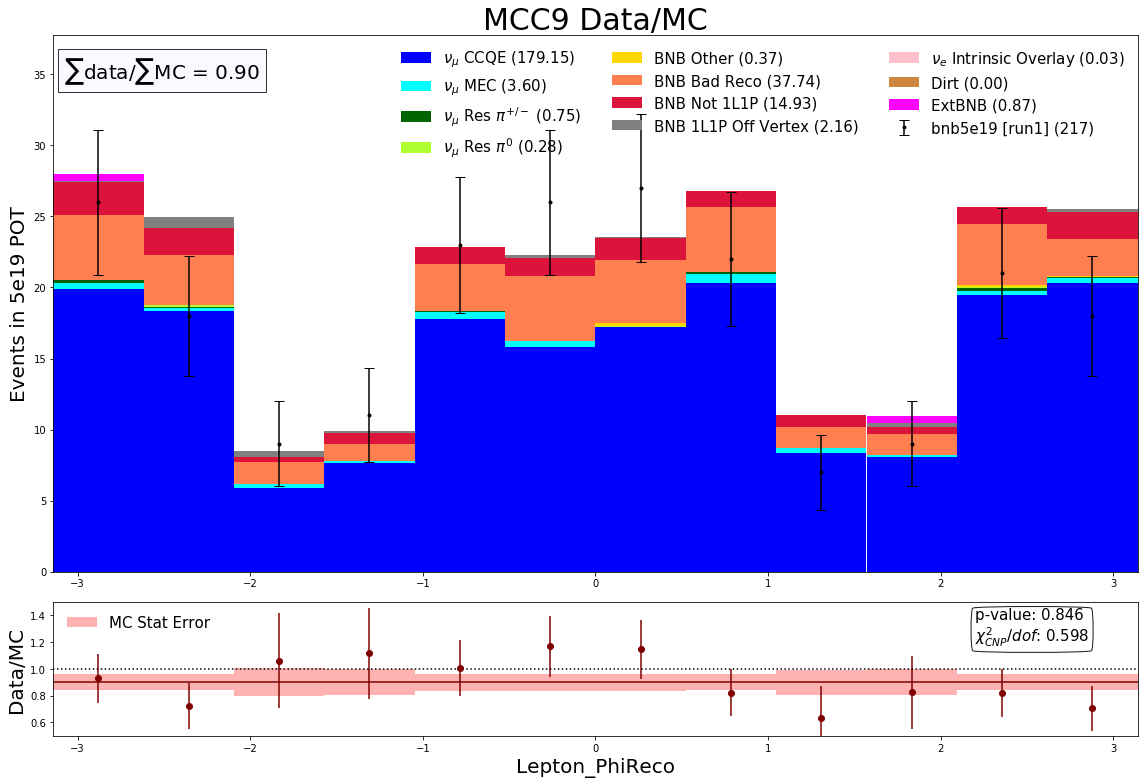

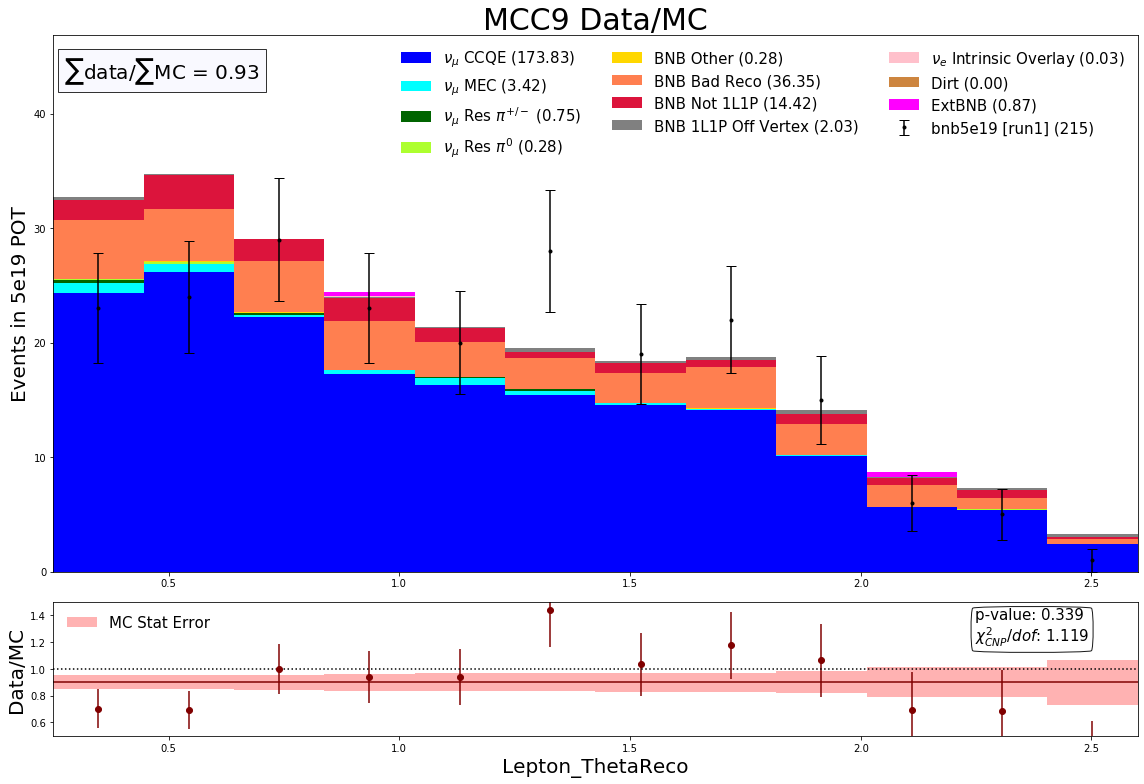

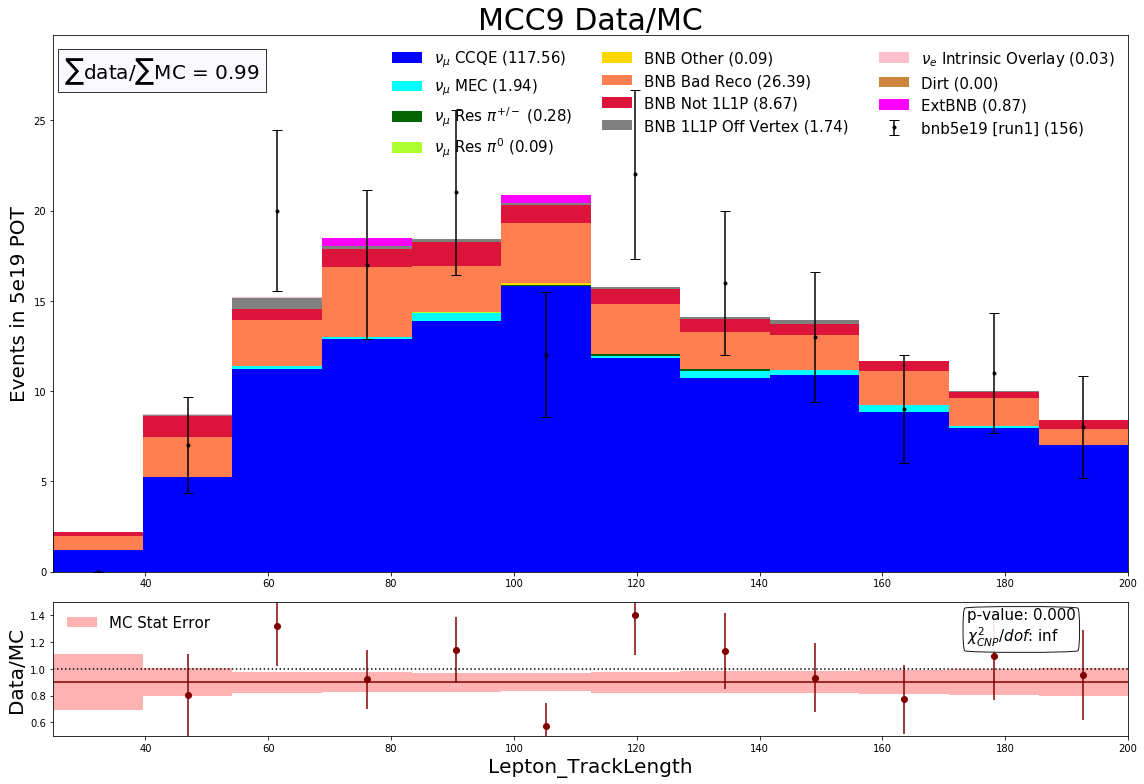

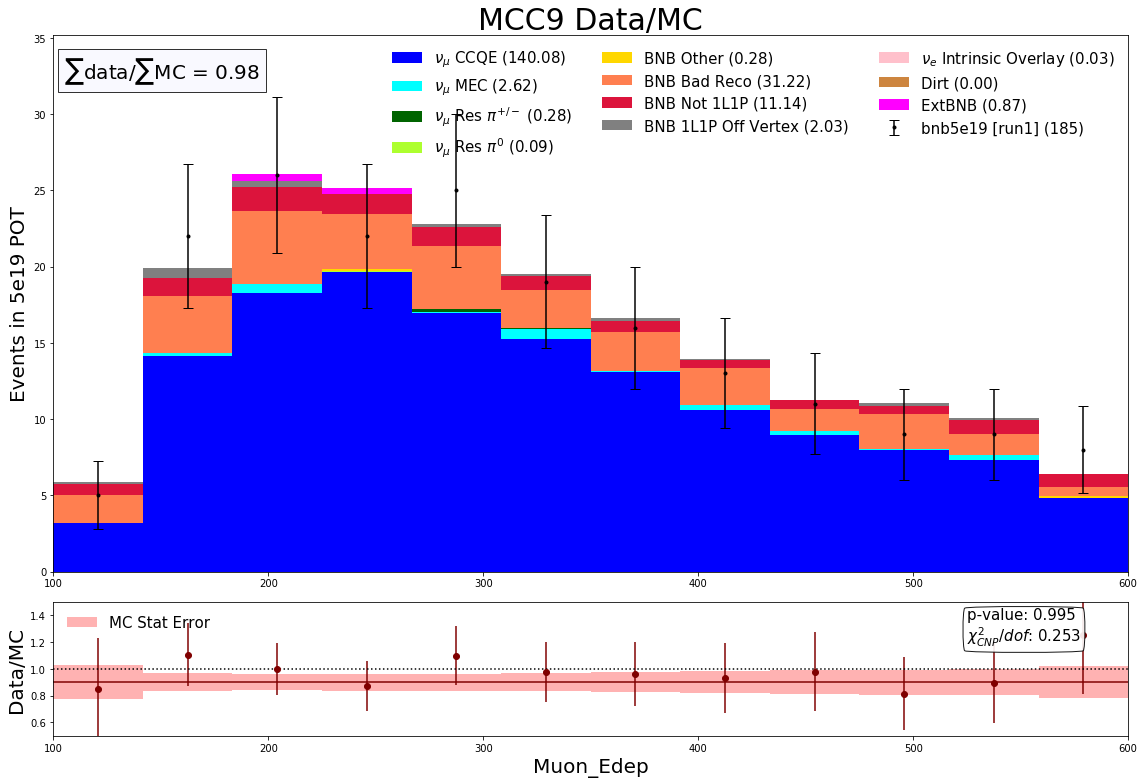

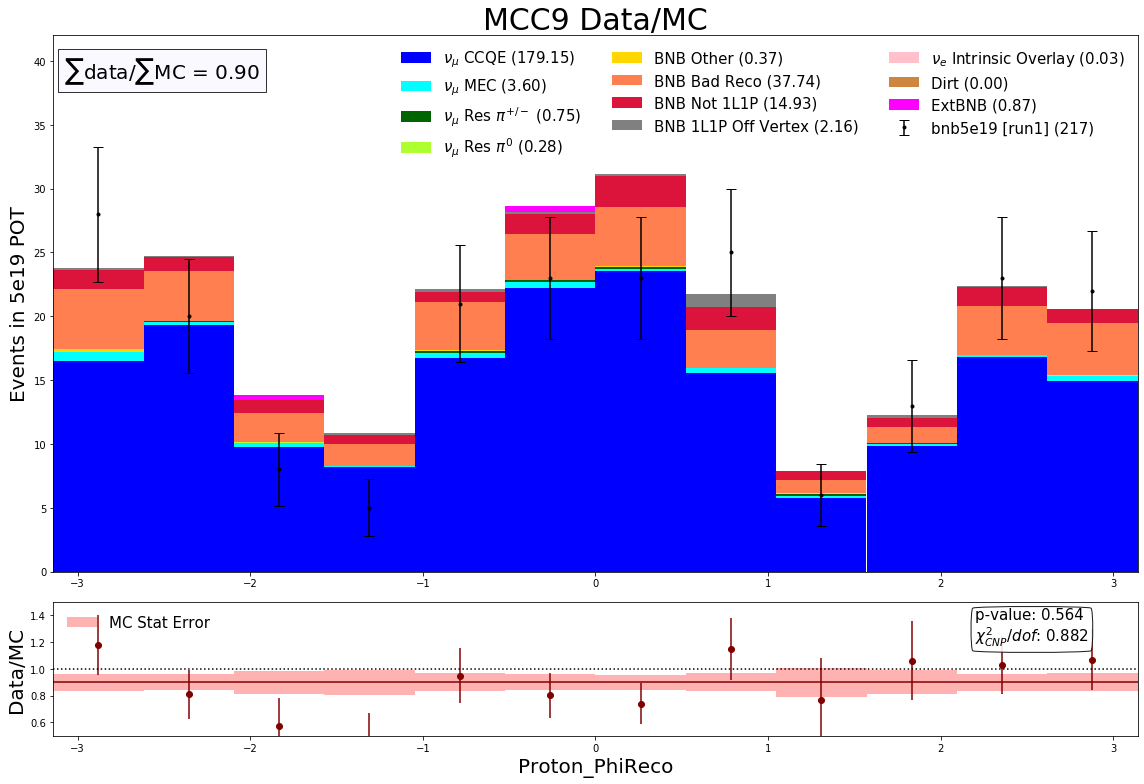

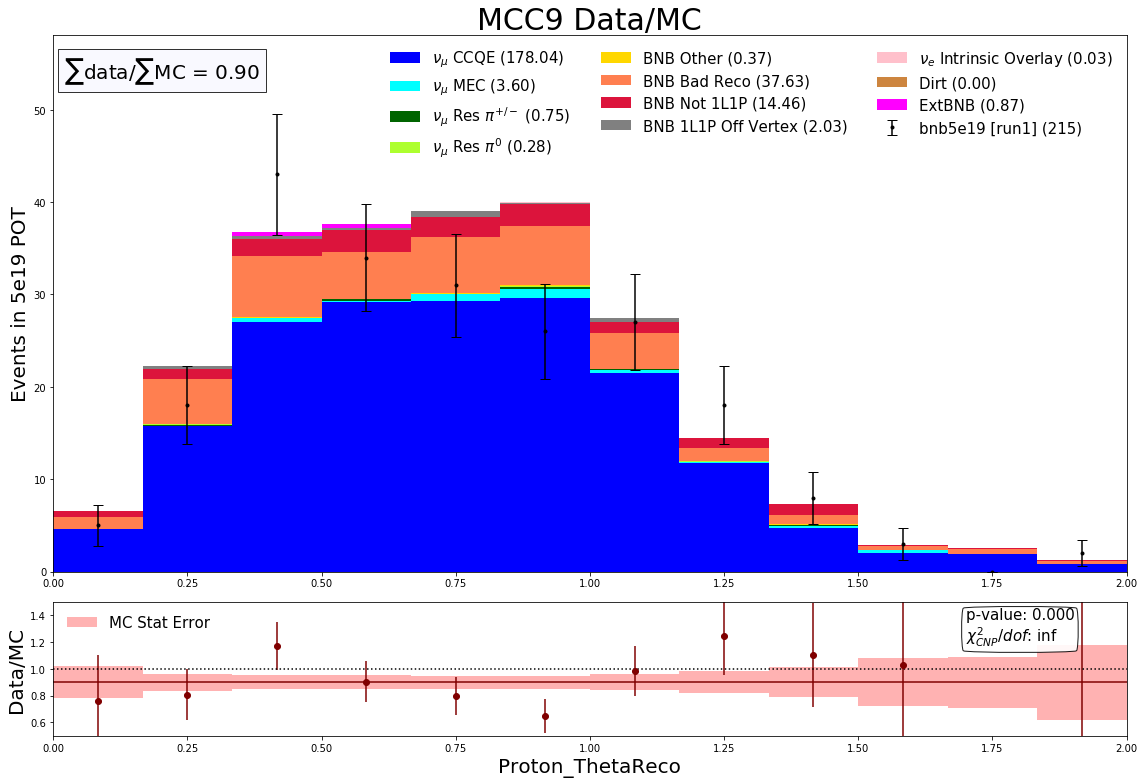

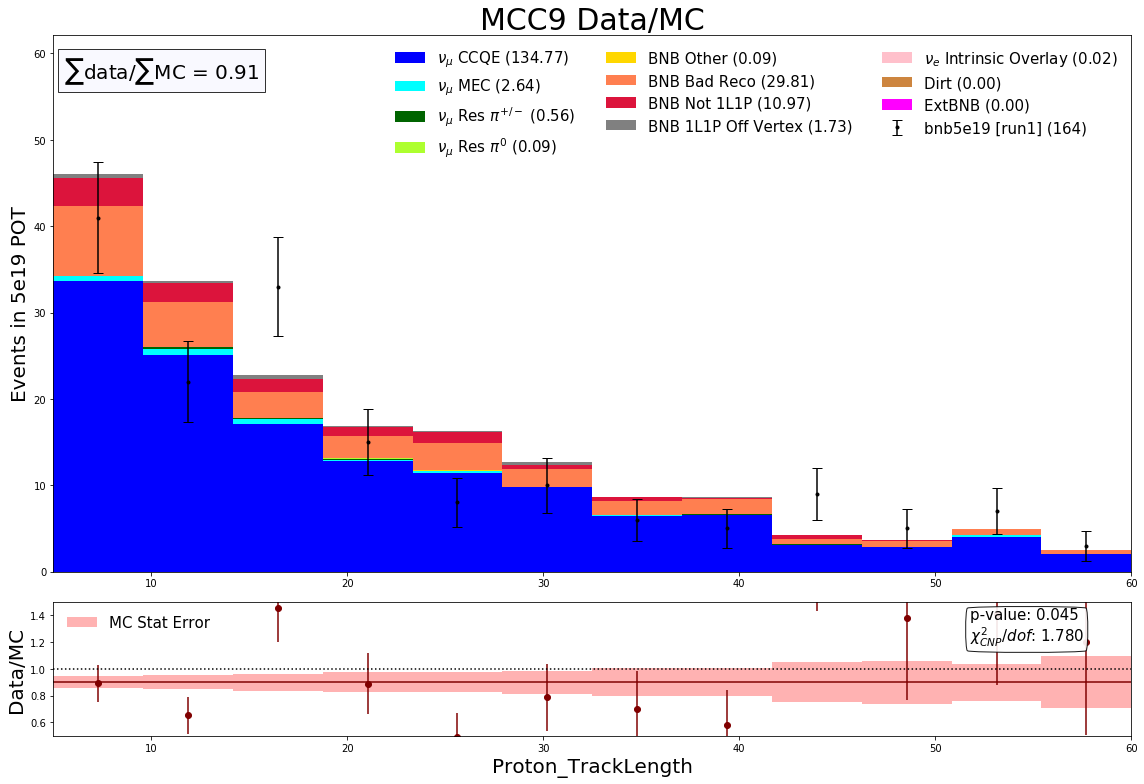

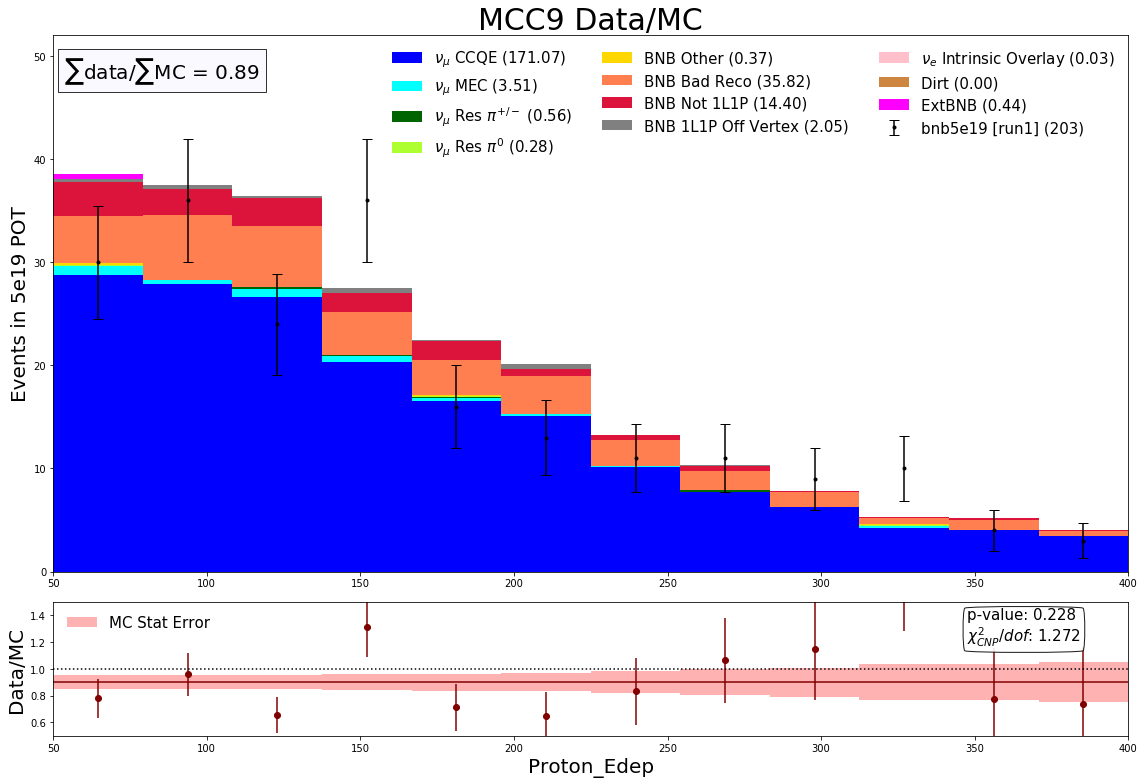

In [57]:
# Big Dumpus (for selected events)
dumphole = 'run1_sel_apr7_normshift'
mybins = 12

plt.ioff()

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlist:
    fig,ax = plt.subplots(figsize=(16,11))
    distplot_wratio(dist.myname,mybins,dist.myrange,sampleHistsSel,run1HistSel,dist.myname,normshift=.9)
    plt.savefig(dumphole+'/'+dist.myname+'.png')

In [20]:
# Print RSE for lauren

selvars = ['run','subrun','event','Xreco','Yreco','Zreco','Enu_1m1p','OpenAng','PT_1m1p','AlphaT_1m1p','BjX_1m1p','BjY_1m1p','Q2_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_ThetaReco','Lepton_TrackLength','Muon_Edep','Proton_PhiReco','Proton_ThetaReco','Proton_TrackLength','Proton_Edep','PTRat_1m1p']

simpleHistsSel[0]._df.query('mc_label not in [[selvars].to_csv('~/Downloads/bnb-postsel_forlauren-apr6.txt',index=False)
simpleHistsSel[1]._df[selvars].to_csv('~/Downloads/nue-postsel_forlauren-apr6.txt',index=False)
simpleHistsSel[2]._df[selvars].to_csv('~/Downloads/dirt-postsel_forlauren-apr6.txt',index=False)
simpleHistsSel[3]._df[selvars].to_csv('~/Downloads/ext-postsel_forlauren-apr6.txt',index=False)

In [ ]:
var1 = 'Xreco'
var2 = 'TotPE'
#ext_var1 = (df_ext_sel[var1].values)
#ext_var2 = (df_ext_sel[var2].values)

#numu_var1 = (df_numu_CCQE_sel[var1].values)
#numu_var2 = (df_numu_CCQE_sel[var2].values)

ext_var1 = (df_data_presel[var1].values)
ext_var2 = (df_data_presel[var2].values)

numu_var1 = (df_numu_CCQE_presel[var1].values)
numu_var2 = (df_numu_CCQE_presel[var2].values)

print(numu_var2.max())

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(numu_var1,numu_var2,color='lavender',alpha=1)
plt.scatter(ext_var1,ext_var2,color='mistyrose',alpha=.9)
sns.kdeplot(numu_var1,numu_var2,label='numu CCQE MC',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(ext_var1,ext_var2,label='data',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='upper right')
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(0,256)
plt.ylim(0,2000)

x0 = np.linspace(0,6)
y0 = -(x0)*300+250
y1 = (x0-2.6)*600

#plt.plot(x0,y0,c='coral')
#plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

## mostly experimental  2d  plots

(0, 3000)

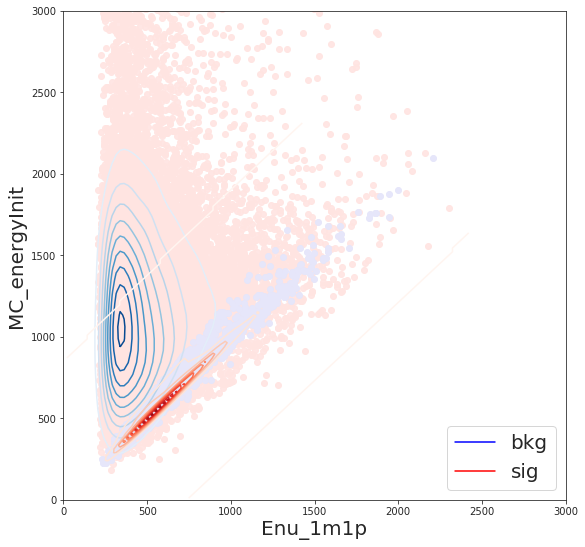

In [131]:
goodreco = 'abs((MC_energyInit-Enu_1m1p)/MC_energyInit) < .2'

df_sig = df_numu_presel.query("mc_label in ['numu_CCQE']")
df_bkg = df_numu_presel.query("mc_label not in ['numu_CCQE']")
#df_nubkg = df_numu_presel.query("mc_label not in ['numu_CCQE'] or not "+goodreco+' or MC_nproton!=1 or MC_nlepton!=1')

#with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_WC_mar26-deepcuts.pickle','rb') as handle: cosmicBDT,nuBDT = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
#vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']
#myvars = vars_cos_allofem
#df_sig.insert(0,'NuBkgScore1',nuBDT.predict(df_nusignal[myvars].values.tolist(),output_margin=True))
#df_bkg.insert(0,'NuBkgScore1',nuBDT.predict(df_extbkg[myvars].values.tolist(),output_margin=True))
#df_nubkg.insert(0,'NuBkgScore1',nuBDT.predict(df_nubkg[myvars].values.tolist(),output_margin=True))


var1 = 'Enu_1m1p'
var2 = 'MC_energyInit'

sig_var1 = df_sig[var1].values
sig_var2 = df_sig[var2].values

bkg1_var1 = df_bkg[var1].values
bkg1_var2 = df_bkg[var2].values


fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(bkg1_var1,bkg1_var2,color='mistyrose',alpha=.9)
#plt.scatter(bkg2_var1,bkg2_var2,color='honeydew',alpha=.9)
plt.scatter(sig_var1,sig_var2,color='lavender',alpha=1)


sns.kdeplot(bkg1_var1,bkg1_var2,label='bkg',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
#sns.kdeplot(bkg2_var1,bkg2_var2,label='nubkg',color='green',cmap='Greens')#,cmap="Reds", shade=True, bw=.15)
sns.kdeplot(sig_var1,sig_var2,label='sig',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='lower right')
plt.xlim(0,3000)
plt.ylim(0,3000)

In [ ]:
var1 = 'Xreco'
var2 = 'TotPE'
#ext_var1 = (df_ext_sel[var1].values)
#ext_var2 = (df_ext_sel[var2].values)

#numu_var1 = (df_numu_CCQE_sel[var1].values)
#numu_var2 = (df_numu_CCQE_sel[var2].values)

ext_var1 = (df_data_presel[var1].values)
ext_var2 = (df_data_presel[var2].values)

numu_var1 = (df_numu_CCQE_presel[var1].values)
numu_var2 = (df_numu_CCQE_presel[var2].values)

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(ext_var1,ext_var2,color='mistyrose',alpha=.9)
plt.scatter(numu_var1,numu_var2,color='lavender',alpha=1)
sns.kdeplot(numu_var1,numu_var2,label='ccqe',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(ext_var1,ext_var2,label='ext',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='lower right')
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,np.pi)
#plt.ylim(-2000,1000)

x0 = np.linspace(0,6)
y0 = (x0-2)*100
y1 = (x0-2.6)*600

plt.plot(x0,y0,c='coral')
#plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

In [ ]:
var1 = 'Xreco'
var2 = 'TotPE'

nbins1 = 20
nbins2 = 20
range1 = (0,250)
range2 = (0,4000)

df_sig = df_data_presel
df_bkg = df_ext_presel

fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

Hsig, xedges, yedges = np.histogram2d(df_sig[var1],df_sig[var2],[nbins1,nbins2],[range1,range2],weights=weights_data_presel,density=1)
Hbkg, _,_ = np.histogram2d(df_bkg[var1],df_bkg[var2],[nbins1,nbins2],[range1,range2],weights=weights_ext_presel,density=1)
Hsig = Hsig.T
Hbkg = Hbkg.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hsig,Hbkg)

#Hrat[Hrat<1] = .000001

crat = ax.pcolormesh(X, Y,(Hsig),cmap='cool')
cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('log(signal/background)', rotation=270,fontsize=10)

plt.xlim(range1)
plt.ylim(range2)
x0 = np.linspace(0,6)

y0 = (x0-1.8)*100
y1 = (x0-2.5)*250

#plt.plot(x0,y0,c='coral')
#plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


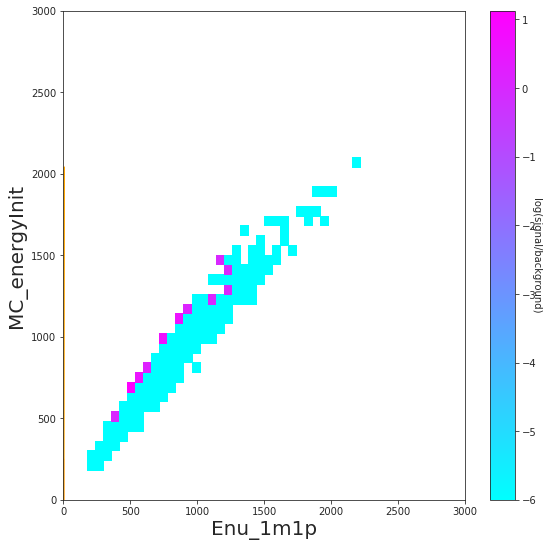

In [24]:
var1 = 'Enu_1m1p'
var2 = 'MC_energyInit'

nbins1 = 50
nbins2 = 50
range1 = (0,3000)
range2 = (0,3000)

df_sig = df_numu_presel.query("mc_label in ['nLmP','offvtx','badreco']")
df_bkg = df_numu_presel.query("mc_label in ['numu_CCQE']")

fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

Hsig, xedges, yedges = np.histogram2d(df_sig[var1],df_sig[var2],[nbins1,nbins2],[range1,range2],density=1)
Hbkg, _,_ = np.histogram2d(df_bkg[var1],df_bkg[var2],[nbins1,nbins2],[range1,range2],density=1)
Hsig = Hsig.T
Hbkg = Hbkg.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hsig,Hbkg)

Hrat[Hrat<1] = .000001

crat = ax.pcolormesh(X, Y, np.log10(Hrat),cmap='cool')
cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('log(signal/background)', rotation=270,fontsize=10)

plt.xlim(range1)
plt.ylim(range2)
x0 = np.linspace(0,6)


y0 = -(x0)*300+250
y1 = (x0-2.6)*600



plt.plot(x0,y0,c='coral')
plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

In [ ]:
var1 = 'Thetas'
var2 = 'ChargeNearTrunk'

nbins1 = 20
nbins2 = 20
range1 = (0,3)
range2 = (0,1000)

df_sig = df_numu_CCQE_presel
df_bkg = df_bnb_offvtx_presel#df_ext_presel

fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

Hsig, xedges, yedges = np.histogram2d(df_sig[var1],df_sig[var2],[nbins1,nbins2],[range1,range2],weights=weights_numu_CCQE_presel,density=1)
Hbkg, _,_ = np.histogram2d(df_bkg[var1],df_bkg[var2],[nbins1,nbins2],[range1,range2],weights=weights_bnb_offvtx_presel,density=1)
Hsig = Hsig.T
Hbkg = Hbkg.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hsig,Hbkg)

Hrat[Hrat<1] = .000001

crat = ax.pcolormesh(X, Y, np.log10(Hrat),cmap='cool')
cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('log(signal/background)', rotation=270,fontsize=10)

plt.xlim(range1)
plt.ylim(range2)
x0 = np.linspace(0,6)


y0 = -(x0)*300+250
y1 = (x0-2.6)*600



plt.plot(x0,y0,c='coral')
plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)